In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import copy
import os
import sys
# custom imports
import utils
import mcts
import train
from rtfm import featurizer as X

Using device cuda:0
Using device cuda:0


In [2]:
skip = True

In [3]:
if not skip:
    ### Define parameters ###
    ucb_C = 1.0
    discount = 0.997
    episode_length = 16
    max_actions = 50
    num_simulations =  50
    device = mcts.device

    flags = utils.Flags(env="rtfm:groups_simple_stationary-v0")
    gym_env = utils.create_env(flags)
    featurizer = X.Render()
    game_simulator = mcts.FullTrueSimulator(gym_env, featurizer)
    #value_net = mcts.FixedDynamicsValueNet(gym_env).to(device)
    value_net = mcts.ValueMLP(gym_env).to(device)
    optimizer = torch.optim.Adam(value_net.parameters(), lr=5e-3)
    loss_fn = F.mse_loss

In [4]:
if not skip:
    value_net = torch.load("value_net")

In [5]:
# interact for episode_length steps with the environment; reset episode if terminal state is reached
if not skip:
    %%time
    total_reward, frame_lst, reward_lst, done_lst = train.play_rollout_value_net(value_net,
                                                                        game_simulator,
                                                                        episode_length,
                                                                        ucb_C,
                                                                        discount,
                                                                        max_actions,
                                                                        num_simulations,
                                                                        mode="predict",
                                                                        render=True
                                                                        )

In [6]:
# cycle just for filling the replay buffer
if not skip:
    %%time
    n_episodes = 300
    memory_size = 1000
    rb = train.ReplayBuffer(memory_size, discount)
    total_rewards = []
    episode_lengths = []
    for i in range(n_episodes):
        t0 = time.time()
        if (i+1)%50 == 0:
            render=True
        else:
            render=False
        total_reward, frame_lst, reward_lst, done_lst = train.play_rollout_value_net(value_net,
                                                                            game_simulator,
                                                                            episode_length,
                                                                            ucb_C,
                                                                            discount,
                                                                            max_actions,
                                                                            num_simulations,
                                                                            mode="simulate",
                                                                            render=render
                                                                            )
        t1 = time.time()
        total_rewards.append(total_reward)
        episode_lengths.append(len(reward_lst))
        print("\nEpisode %d - Total reward %d"%(i+1, total_reward))
        rollout_time = (t1-t0)/60
        print("Rollout time: %.2f"%(rollout_time))
        rb.store_episode(frame_lst, reward_lst, done_lst)

In [7]:
if not skip:
    rb = torch.load("replay_buffer")

In [8]:
# cycle for training the value net offline
if not skip:
    n_updates = 1000
    losses = []
    for i in range(n_updates):
        frames, targets = rb.get_batch(64)
        reshaped_frames = {}
        for k in frames.keys():
            shape = frames[k].shape
            reshaped_frames[k] = frames[k].reshape(-1,*shape[2:])
        targets = targets.reshape(-1).to(device)
        values = value_net(reshaped_frames).squeeze(1)

        loss = loss_fn(values, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print("Update: %d - Loss: %.4f"%(i+1,loss.item()))
        losses.append(loss.item())

In [9]:
# compare simulate, predict, simulate and predict and hybrid methods in MCTS given the value net
if not skip:
    train.compare_modes(game_simulator, value_net, episode_length, ucb_C, discount, max_actions, num_simulations)

## Main training cycle

In [4]:
%%time
# Full training cycle

ucb_C = 1.0
discount = 0.997
episode_length = 16
max_actions = 5
num_simulations = 50
device = mcts.device
n_episodes = 1000
memory_size = 528
batch_size = 32

flags = utils.Flags(env="rtfm:groups_simple_stationary-v0")
gym_env = utils.create_env(flags)
featurizer = X.Render()
game_simulator = mcts.FullTrueSimulator(gym_env, featurizer)
value_net = mcts.FixedDynamicsValueNet_v1(gym_env).to(device)
#value_net = mcts.ValueMLP(gym_env).to(device)
optimizer = torch.optim.Adam(value_net.parameters(), lr=1e-3)
loss_fn = F.mse_loss
rb = train.ReplayBuffer(memory_size, discount)

total_rewards = []
episode_lengths = []
losses = []
mode_scores = []
for i in range(n_episodes):
    ### Generate experience ###
    t0 = time.time()
    #modes = ["simulate", "predict", "simulate_and_predict"]
    modes=["predict"]
    mode = np.random.choice(modes)
    total_reward, frame_lst, reward_lst, done_lst = train.play_rollout_value_net(value_net,
                                                                                game_simulator,
                                                                                episode_length,
                                                                                ucb_C,
                                                                                discount,
                                                                                max_actions,
                                                                                num_simulations,
                                                                                mode=mode,
                                                                                bootstrap="root_value"
                                                                                )
    t1 = time.time()
    total_rewards.append(total_reward)
    episode_lengths.append(len(reward_lst))
    print("\nEpisode %d - Total reward %d"%(i+1, total_reward))
    rollout_time = (t1-t0)/60
    print("Rollout time: %.2f"%(rollout_time))
    rb.store_episode(frame_lst, reward_lst, done_lst)
    
    ### Train value_net ###
    if (i+1)%16==0: # diluting the updates in order to have more fresh experience
        try:
            frames, targets = rb.get_batch(batch_size)
            loss = train.compute_update(value_net, frames, targets, loss_fn, optimizer)
            print("Loss: %.4f"%loss)
            losses.append(loss)
        except:
            pass
    
    ### Test MCTS in the three different modes
    if (i+1)%100 == 0:
        print("\nTest time:")
        scores = train.compare_modes(game_simulator, 
                               value_net, 
                               episode_length, 
                               ucb_C, 
                               discount, 
                               max_actions, 
                               num_simulations,
                               n_episodes=10
                              )
        print("Average return in simulate mode: ", scores[0])
        print("Average return in predict mode: ", scores[1])
        print("Average return in simulate and predict mode: ", scores[2])
        print("Average return in hybrid mode: ", scores[3])
        mode_scores.append(scores)


Episode 1 - Total reward 0
Rollout time: 0.16

Episode 2 - Total reward 2
Rollout time: 0.11

Episode 3 - Total reward 2
Rollout time: 0.11


KeyboardInterrupt: 

## New training cycle

What changes:
1. Bootstrapping done at update time and not at the end of an episode while playing
2. Boostrap value given by a target network, which is a  copy of the value network with more conservative updates
3. The target value is the (at most) n-step cumulative reward + discounted value of the n-th state

In [2]:
# Full training cycle
ucb_C = 1.0
discount = 0.9 # try with smaller discount
episode_length = 32
max_actions = 5
num_simulations = 50
device = mcts.device
n_episodes = 2000
memory_size = 528
batch_size = 32
n_steps = 5
tau = 0.5 # new_trg_params = (1-tau)*old_trg_params + tau*value_net_params

training_params = dict(
    ucb_C = 1.0,
    discount = 0.9, 
    episode_length = 32,
    max_actions = 5,
    num_simulations = 50,
    device = mcts.device,
    n_episodes = 2000,
    memory_size = 528,
    batch_size = 32,
    n_steps = 5,
    tau = 0.5 
)

In [3]:
training_params

{'ucb_C': 1.0,
 'discount': 0.9,
 'episode_length': 32,
 'max_actions': 5,
 'num_simulations': 50,
 'device': 'cuda:0',
 'n_episodes': 2000,
 'memory_size': 528,
 'batch_size': 32,
 'n_steps': 5,
 'tau': 0.5}

In [5]:
flags = utils.Flags(env="rtfm:groups_simple_stationary-v0")
gym_env = utils.create_env(flags)
featurizer = X.Render()
game_simulator = mcts.FullTrueSimulator(gym_env, featurizer)

value_net = mcts.FixedDynamicsValueNet_v2(gym_env).to(device)
target_net = mcts.FixedDynamicsValueNet_v2(gym_env).to(device)
# Init target_net with same parameters of value_net
for trg_params, params in zip(target_net.parameters(), value_net.parameters()):
            trg_params.data.copy_(params.data)
        
optimizer = torch.optim.Adam(value_net.parameters(), lr=1e-3)
gamma = 10**(-2/(n_episodes-1)) # decrease lr of 2 order of magnitude during training
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)
loss_fn = F.mse_loss
rb = train.nStepsReplayBuffer(memory_size, discount)

In [6]:
object_ids = utils.get_object_ids_dict(game_simulator)

In [7]:
ID = "AAD"


Episode 1 - Total reward 0
Rollout time: 0.17

Episode 2 - Total reward 1
Rollout time: 0.15

Episode 3 - Total reward 1
Rollout time: 0.15

Episode 4 - Total reward 0
Rollout time: 0.17

Episode 5 - Total reward 1
Rollout time: 0.17

Episode 6 - Total reward 0
Rollout time: 0.17

Episode 7 - Total reward 0
Rollout time: 0.20

Episode 8 - Total reward 1
Rollout time: 0.17

Episode 9 - Total reward 2
Rollout time: 0.15

Episode 10 - Total reward 0
Rollout time: 0.20

Episode 11 - Total reward 2
Rollout time: 0.15

Episode 12 - Total reward 0
Rollout time: 0.21

Episode 13 - Total reward 2
Rollout time: 0.17

Episode 14 - Total reward 0
Rollout time: 0.20

Episode 15 - Total reward 2
Rollout time: 0.14

Episode 16 - Total reward 0
Rollout time: 0.18

Episode 17 - Total reward 0
Rollout time: 0.18

Episode 18 - Total reward 0
Rollout time: 0.21

Episode 19 - Total reward 0
Rollout time: 0.21

Episode 20 - Total reward 0
Rollout time: 0.21

Episode 21 - Total reward 1
Rollout time: 0.16



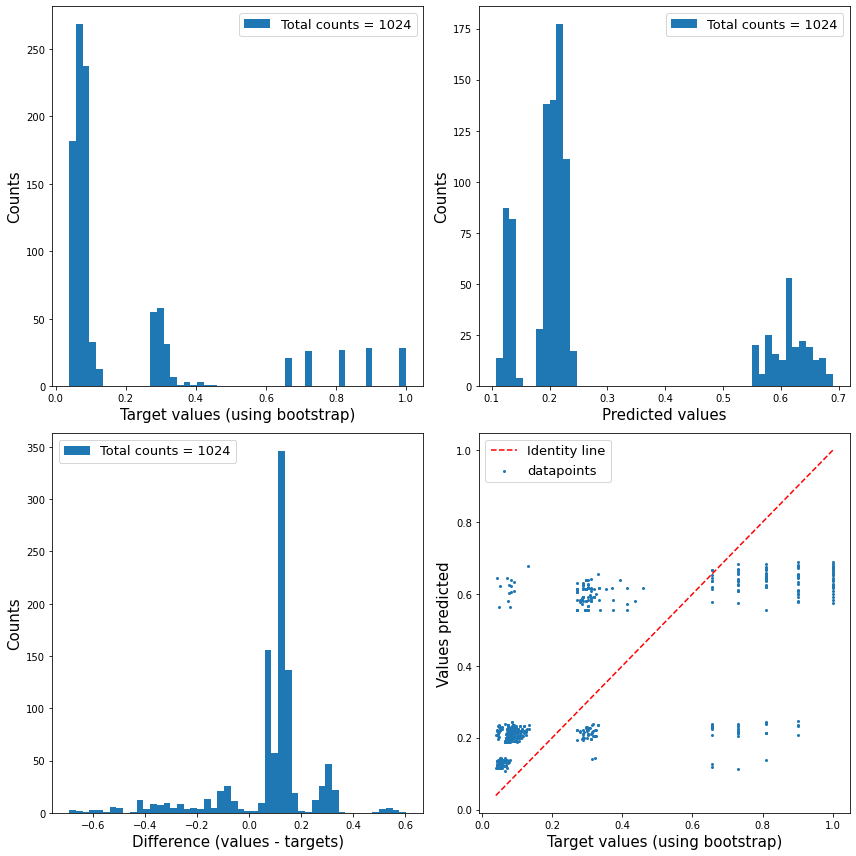

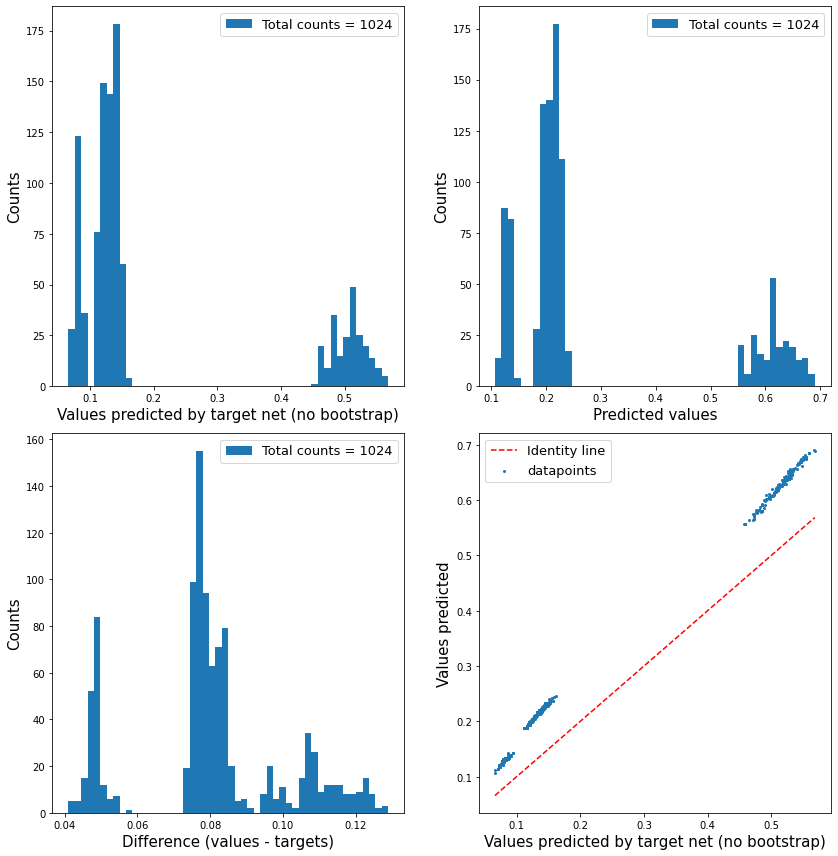

Saved checkpoint.

Episode 101 - Total reward 0
Rollout time: 0.20
Loss: 0.0481

Episode 102 - Total reward 1
Rollout time: 0.18
Loss: 0.0452

Episode 103 - Total reward 2
Rollout time: 0.14
Loss: 0.0497

Episode 104 - Total reward 0
Rollout time: 0.17
Loss: 0.0634

Episode 105 - Total reward 2
Rollout time: 0.14
Loss: 0.0513

Episode 106 - Total reward 4
Rollout time: 0.12
Loss: 0.0496

Episode 107 - Total reward 4
Rollout time: 0.12
Loss: 0.0545

Episode 108 - Total reward 2
Rollout time: 0.16
Loss: 0.0562

Episode 109 - Total reward 1
Rollout time: 0.15
Loss: 0.0529

Episode 110 - Total reward 1
Rollout time: 0.17
Loss: 0.0477

Episode 111 - Total reward 2
Rollout time: 0.15
Loss: 0.0539

Episode 112 - Total reward 0
Rollout time: 0.17
Loss: 0.0641

Episode 113 - Total reward 3
Rollout time: 0.13
Loss: 0.0481

Episode 114 - Total reward 2
Rollout time: 0.13
Loss: 0.0381

Episode 115 - Total reward 2
Rollout time: 0.15
Loss: 0.0552

Episode 116 - Total reward 0
Rollout time: 0.17
Los

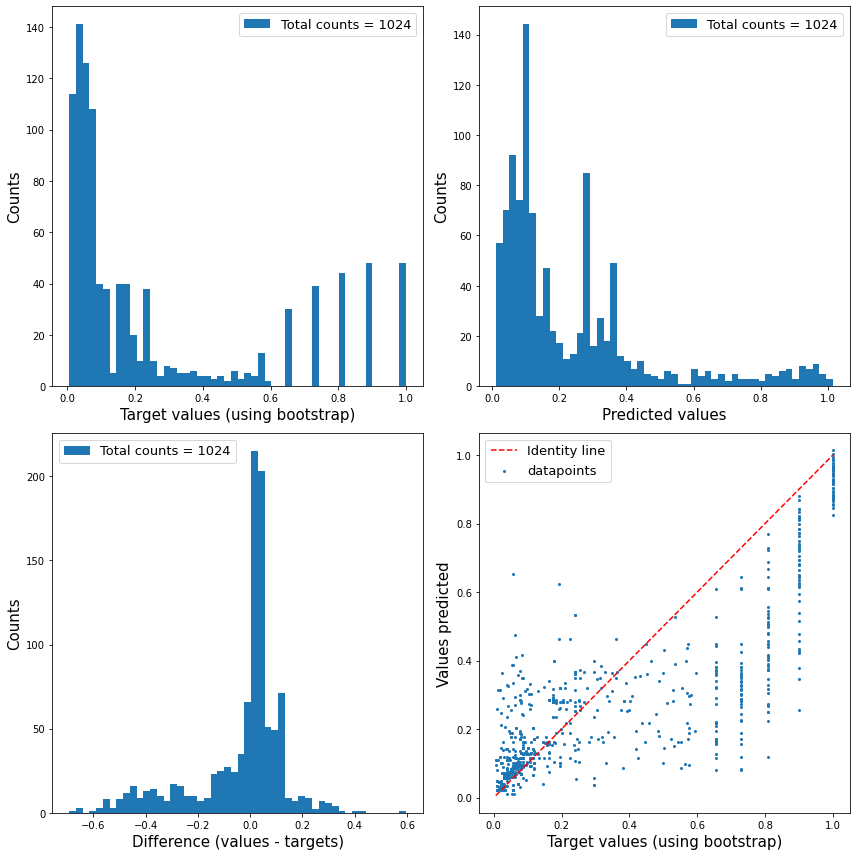

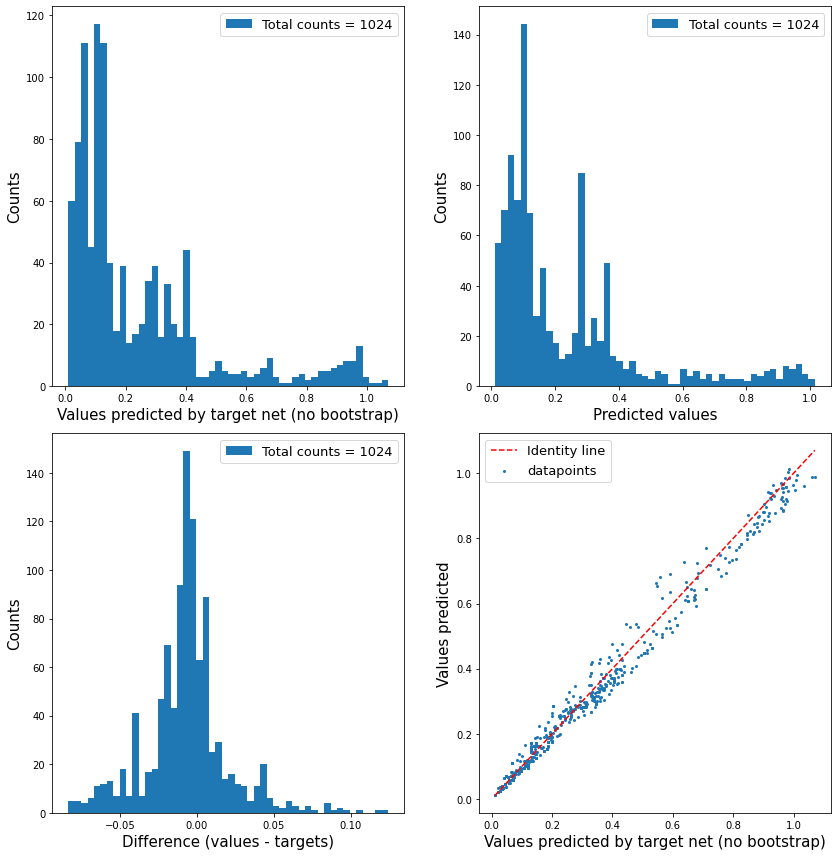

Saved checkpoint.

Episode 201 - Total reward 4
Rollout time: 0.12
Loss: 0.0322

Episode 202 - Total reward 6
Rollout time: 0.11
Loss: 0.0301

Episode 203 - Total reward 0
Rollout time: 0.17
Loss: 0.0439

Episode 204 - Total reward 0
Rollout time: 0.17
Loss: 0.0430

Episode 205 - Total reward 3
Rollout time: 0.13
Loss: 0.0362

Episode 206 - Total reward 3
Rollout time: 0.14
Loss: 0.0368

Episode 207 - Total reward 5
Rollout time: 0.13
Loss: 0.0406

Episode 208 - Total reward 4
Rollout time: 0.13
Loss: 0.0371

Episode 209 - Total reward 0
Rollout time: 0.17
Loss: 0.0323

Episode 210 - Total reward 2
Rollout time: 0.15
Loss: 0.0262

Episode 211 - Total reward 3
Rollout time: 0.13
Loss: 0.0483

Episode 212 - Total reward 5
Rollout time: 0.12
Loss: 0.0410

Episode 213 - Total reward 3
Rollout time: 0.14
Loss: 0.0340

Episode 214 - Total reward 6
Rollout time: 0.13
Loss: 0.0476

Episode 215 - Total reward 6
Rollout time: 0.12
Loss: 0.0426

Episode 216 - Total reward 6
Rollout time: 0.11
Los

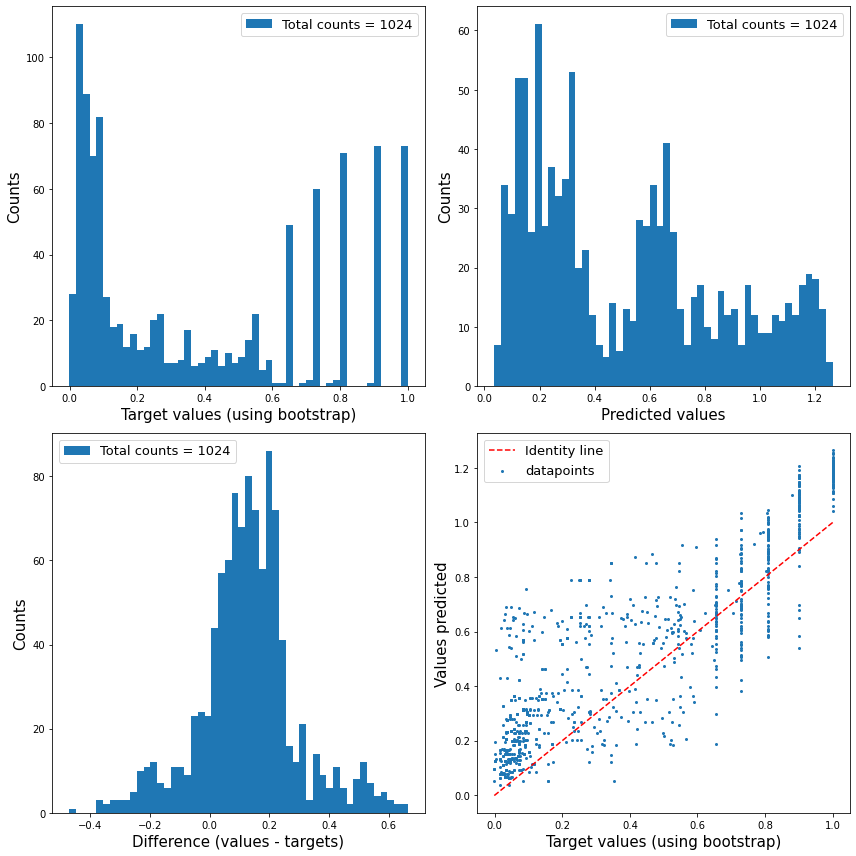

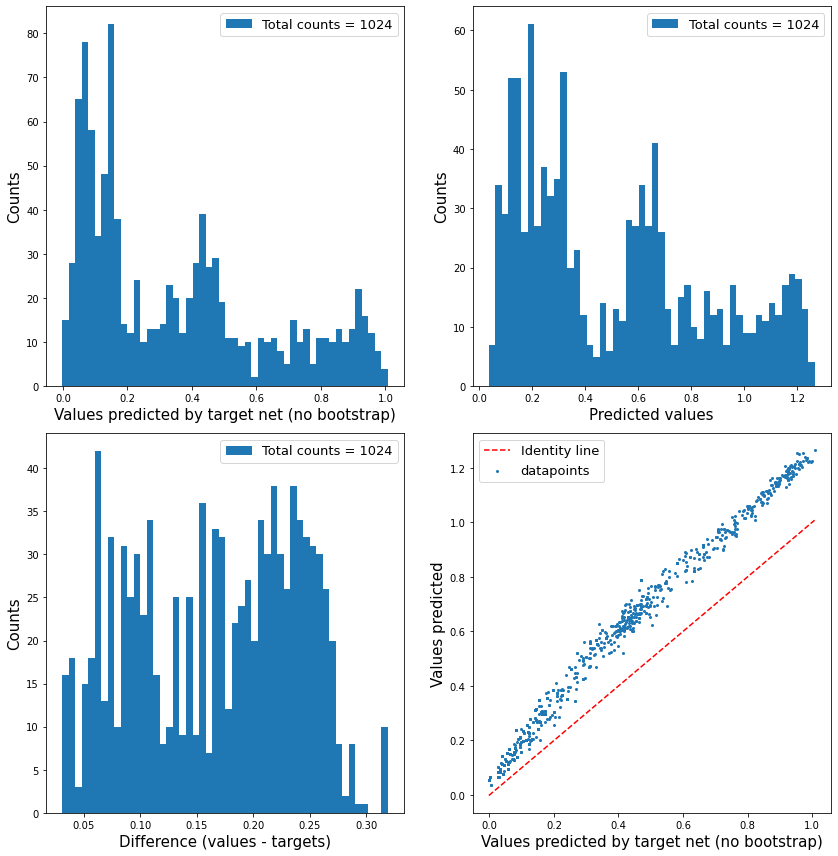

Saved checkpoint.

Episode 301 - Total reward 4
Rollout time: 0.14
Loss: 0.0304

Episode 302 - Total reward 0
Rollout time: 0.17
Loss: 0.0223

Episode 303 - Total reward 5
Rollout time: 0.13
Loss: 0.0232

Episode 304 - Total reward 4
Rollout time: 0.14
Loss: 0.0217

Episode 305 - Total reward 2
Rollout time: 0.17
Loss: 0.0285

Episode 306 - Total reward 6
Rollout time: 0.12
Loss: 0.0258

Episode 307 - Total reward 0
Rollout time: 0.20
Loss: 0.0236

Episode 308 - Total reward 4
Rollout time: 0.13
Loss: 0.0314

Episode 309 - Total reward 3
Rollout time: 0.13
Loss: 0.0272

Episode 310 - Total reward 2
Rollout time: 0.17
Loss: 0.0276

Episode 311 - Total reward 7
Rollout time: 0.11
Loss: 0.0185

Episode 312 - Total reward 2
Rollout time: 0.15
Loss: 0.0303

Episode 313 - Total reward 5
Rollout time: 0.12
Loss: 0.0324

Episode 314 - Total reward 0
Rollout time: 0.17
Loss: 0.0281

Episode 315 - Total reward 6
Rollout time: 0.12
Loss: 0.0312

Episode 316 - Total reward 6
Rollout time: 0.12
Los

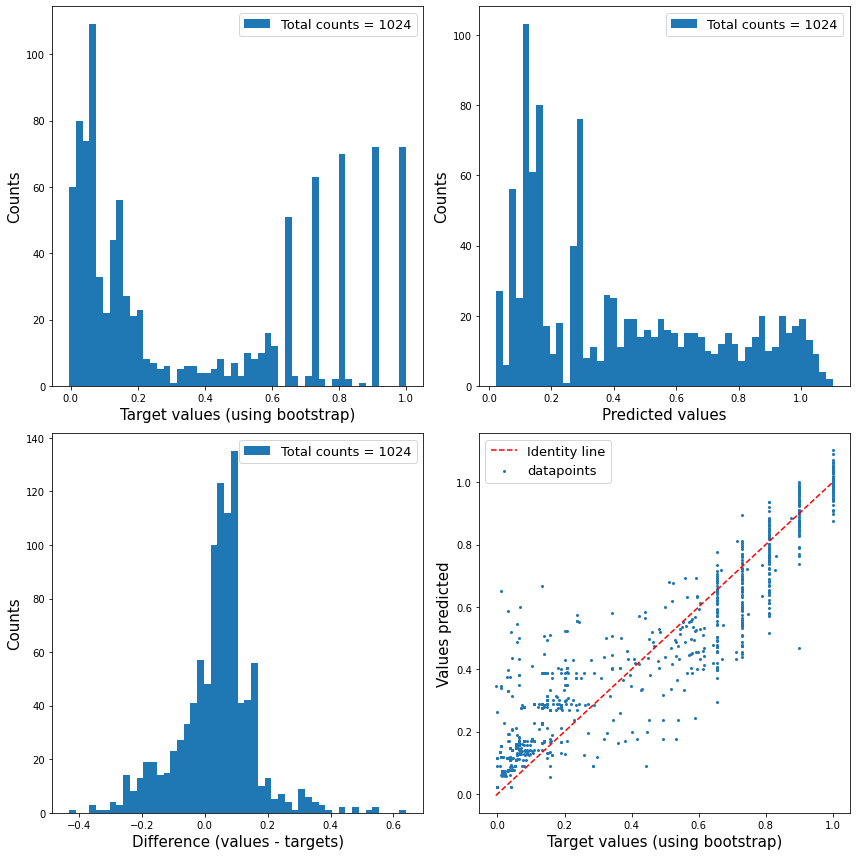

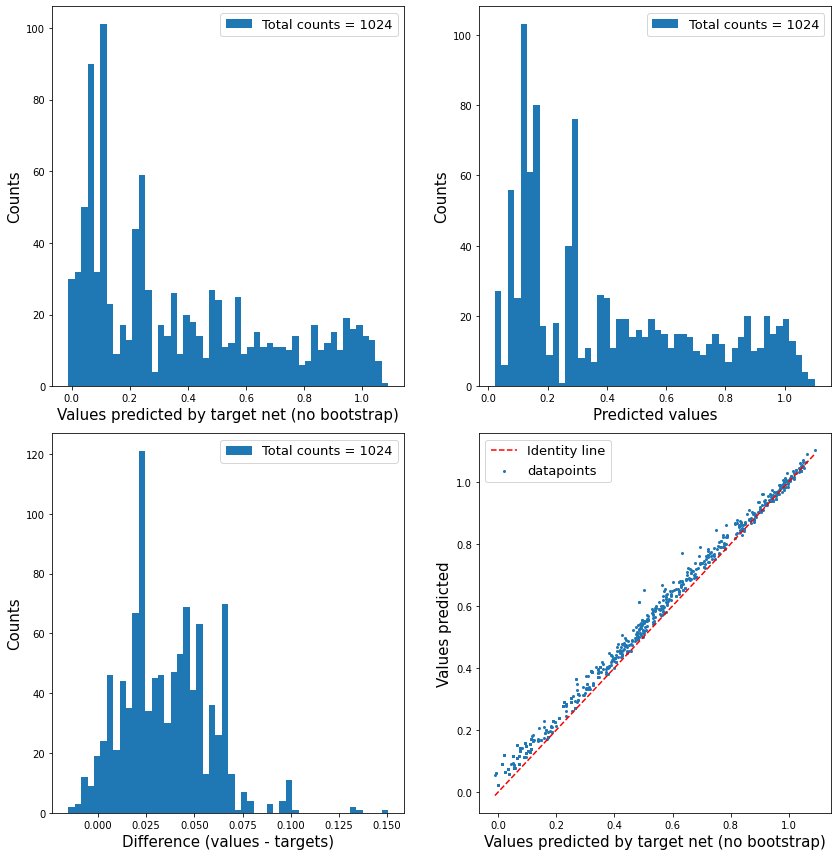

Saved checkpoint.

Episode 401 - Total reward 4
Rollout time: 0.13
Loss: 0.0237

Episode 402 - Total reward 5
Rollout time: 0.13
Loss: 0.0211

Episode 403 - Total reward 4
Rollout time: 0.13
Loss: 0.0268

Episode 404 - Total reward 4
Rollout time: 0.12
Loss: 0.0213

Episode 405 - Total reward 3
Rollout time: 0.14
Loss: 0.0193

Episode 406 - Total reward 4
Rollout time: 0.12
Loss: 0.0190

Episode 407 - Total reward 5
Rollout time: 0.12
Loss: 0.0216

Episode 408 - Total reward 4
Rollout time: 0.13
Loss: 0.0208

Episode 409 - Total reward 4
Rollout time: 0.13
Loss: 0.0205

Episode 410 - Total reward 2
Rollout time: 0.15
Loss: 0.0211

Episode 411 - Total reward 4
Rollout time: 0.13
Loss: 0.0193

Episode 412 - Total reward 3
Rollout time: 0.14
Loss: 0.0206

Episode 413 - Total reward 4
Rollout time: 0.12
Loss: 0.0222

Episode 414 - Total reward 5
Rollout time: 0.12
Loss: 0.0186

Episode 415 - Total reward 2
Rollout time: 0.15
Loss: 0.0196

Episode 416 - Total reward 6
Rollout time: 0.12
Los

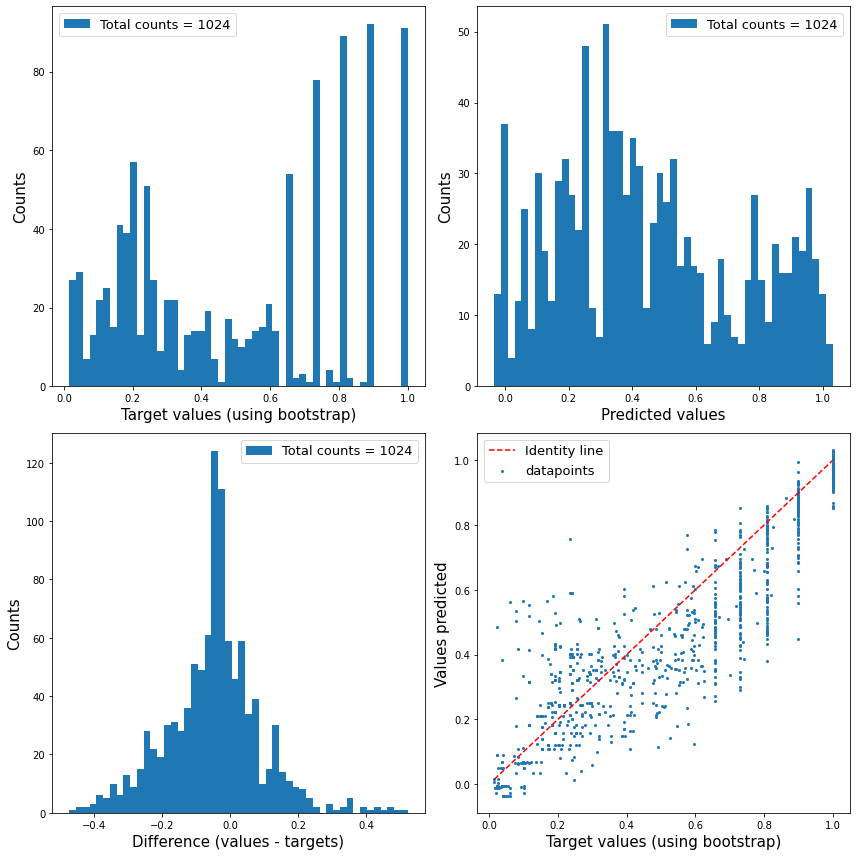

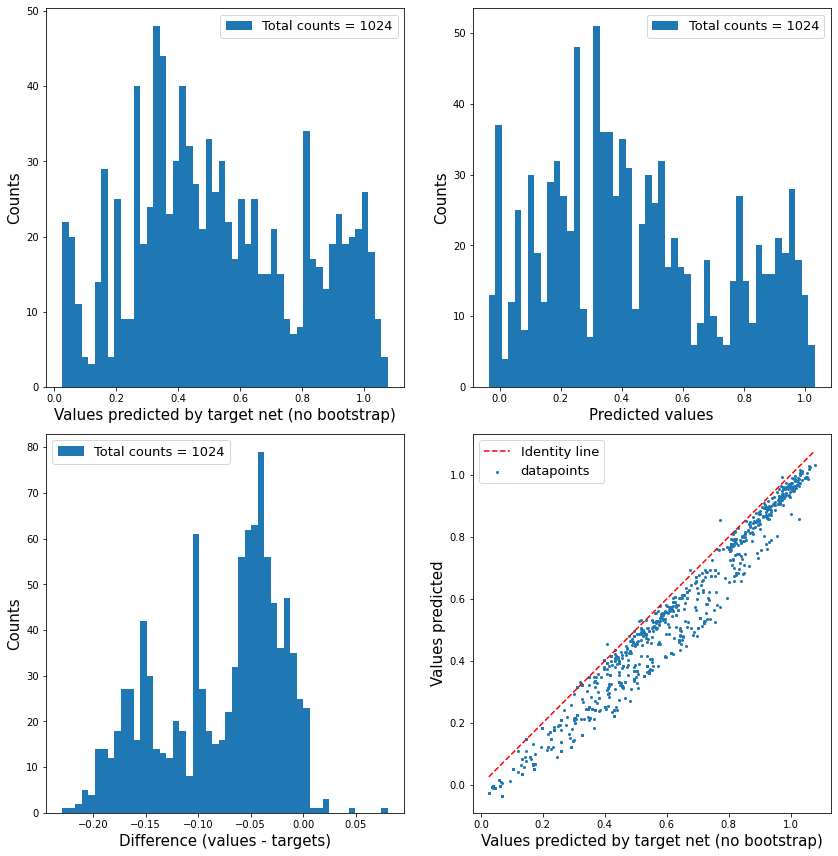

Saved checkpoint.

Episode 501 - Total reward 1
Rollout time: 0.17
Loss: 0.0137

Episode 502 - Total reward 1
Rollout time: 0.15
Loss: 0.0162

Episode 503 - Total reward 3
Rollout time: 0.13
Loss: 0.0199

Episode 504 - Total reward 5
Rollout time: 0.12
Loss: 0.0189

Episode 505 - Total reward 4
Rollout time: 0.13
Loss: 0.0183

Episode 506 - Total reward 4
Rollout time: 0.13
Loss: 0.0184

Episode 507 - Total reward 4
Rollout time: 0.13
Loss: 0.0159

Episode 508 - Total reward 0
Rollout time: 0.20
Loss: 0.0208

Episode 509 - Total reward 0
Rollout time: 0.17
Loss: 0.0163

Episode 510 - Total reward 4
Rollout time: 0.13
Loss: 0.0176

Episode 511 - Total reward 4
Rollout time: 0.13
Loss: 0.0190

Episode 512 - Total reward 2
Rollout time: 0.14
Loss: 0.0169

Episode 513 - Total reward 4
Rollout time: 0.14
Loss: 0.0201

Episode 514 - Total reward 3
Rollout time: 0.14
Loss: 0.0205

Episode 515 - Total reward 2
Rollout time: 0.15
Loss: 0.0156

Episode 516 - Total reward 1
Rollout time: 0.16
Los

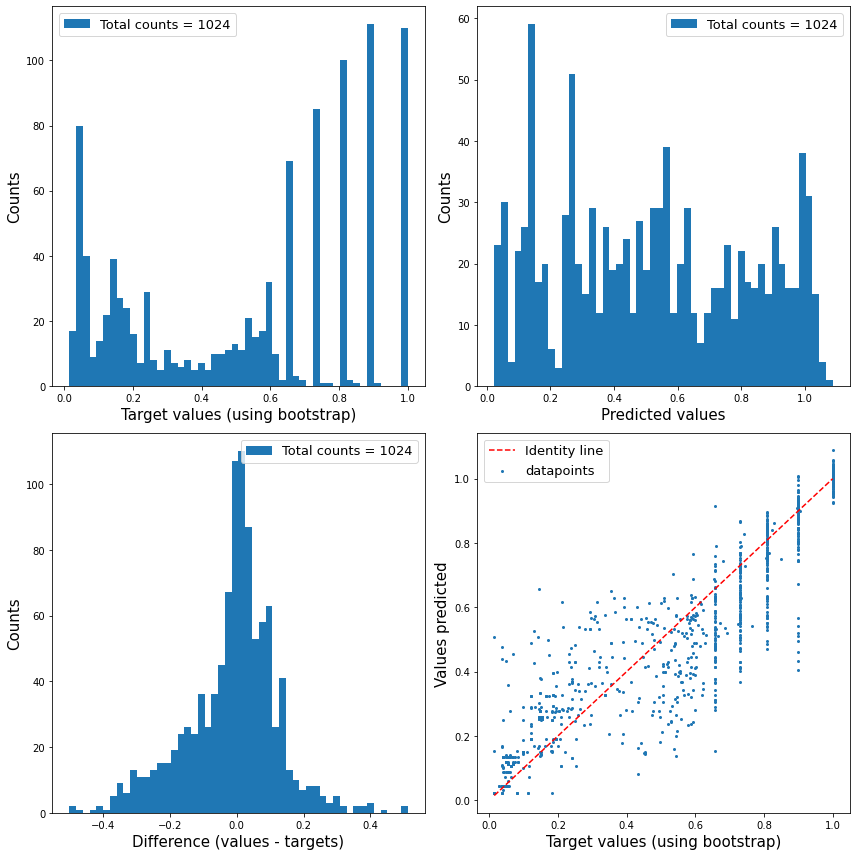

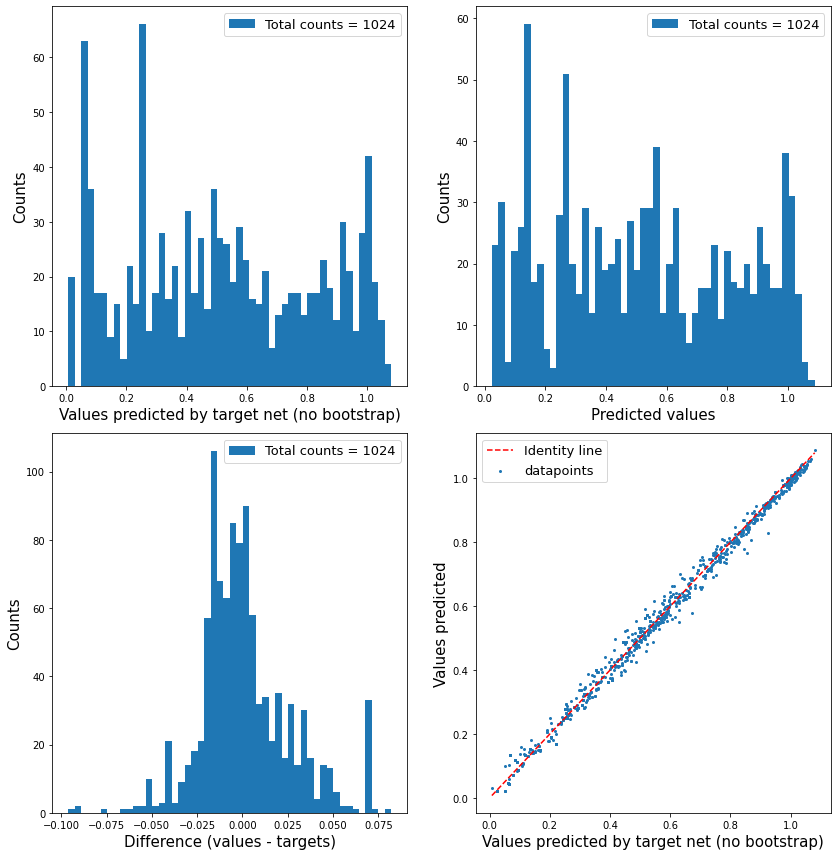

Saved checkpoint.

Episode 601 - Total reward 5
Rollout time: 0.12
Loss: 0.0172

Episode 602 - Total reward 1
Rollout time: 0.16
Loss: 0.0163

Episode 603 - Total reward 2
Rollout time: 0.14
Loss: 0.0193

Episode 604 - Total reward 7
Rollout time: 0.11
Loss: 0.0184

Episode 605 - Total reward 0
Rollout time: 0.17
Loss: 0.0155

Episode 606 - Total reward 0
Rollout time: 0.20
Loss: 0.0178

Episode 607 - Total reward 4
Rollout time: 0.14
Loss: 0.0174

Episode 608 - Total reward 6
Rollout time: 0.12
Loss: 0.0160

Episode 609 - Total reward 3
Rollout time: 0.15
Loss: 0.0202

Episode 610 - Total reward 6
Rollout time: 0.12
Loss: 0.0189

Episode 611 - Total reward 1
Rollout time: 0.17
Loss: 0.0166

Episode 612 - Total reward 6
Rollout time: 0.11
Loss: 0.0180

Episode 613 - Total reward 5
Rollout time: 0.13
Loss: 0.0186

Episode 614 - Total reward 7
Rollout time: 0.12
Loss: 0.0147

Episode 615 - Total reward 4
Rollout time: 0.12
Loss: 0.0169

Episode 616 - Total reward 5
Rollout time: 0.13
Los

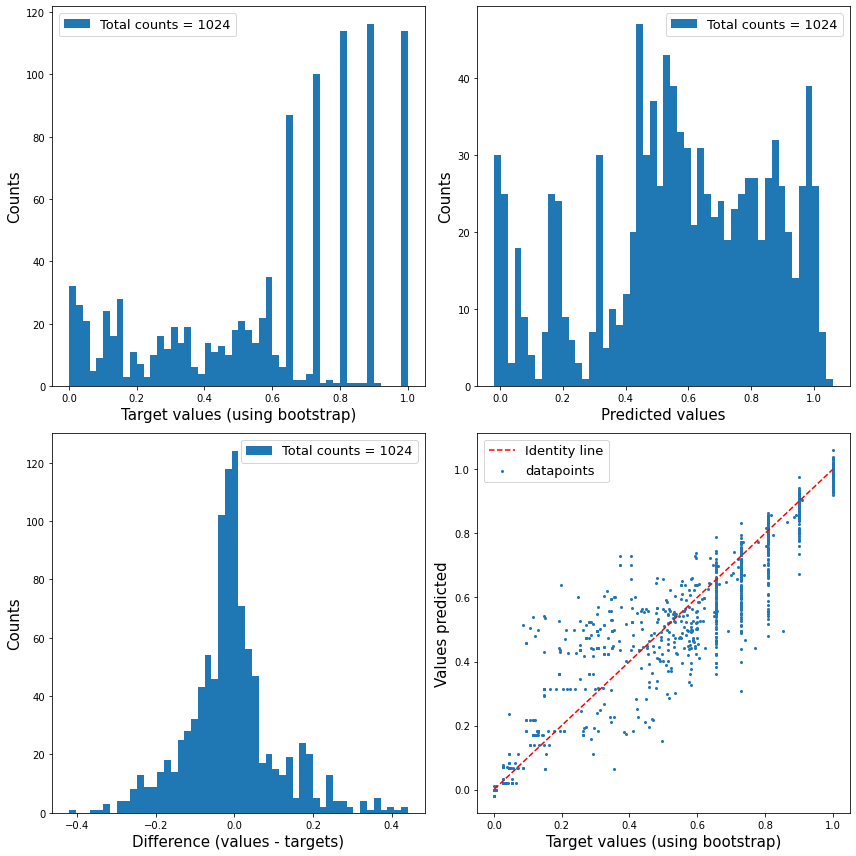

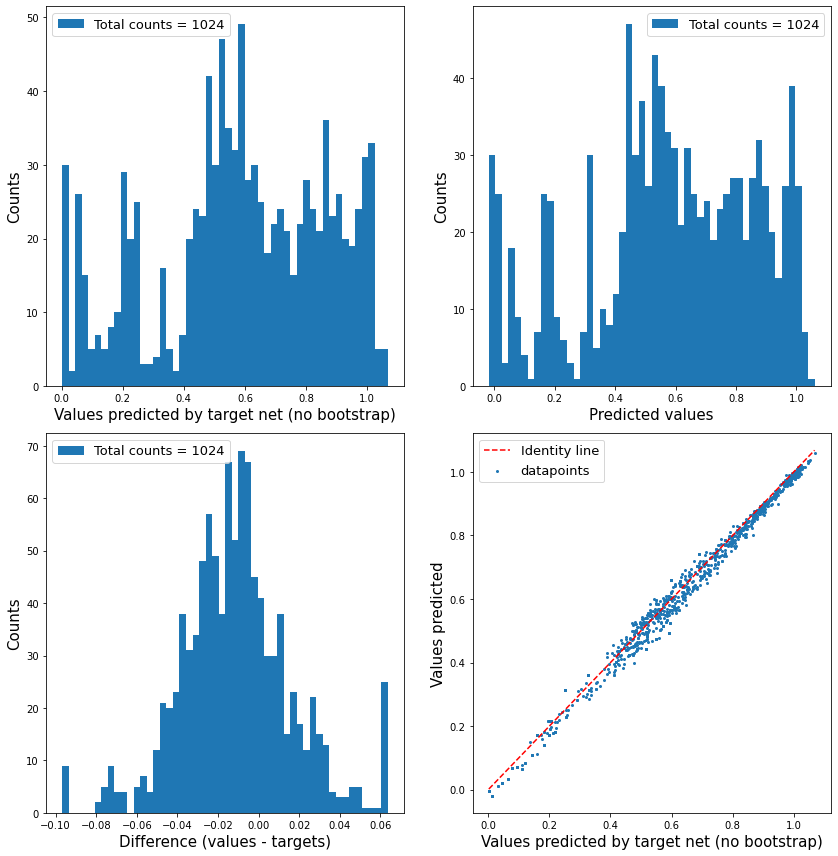

Saved checkpoint.

Episode 701 - Total reward 4
Rollout time: 0.13
Loss: 0.0139

Episode 702 - Total reward 3
Rollout time: 0.14
Loss: 0.0148

Episode 703 - Total reward 5
Rollout time: 0.12
Loss: 0.0129

Episode 704 - Total reward 0
Rollout time: 0.17
Loss: 0.0129

Episode 705 - Total reward 3
Rollout time: 0.13
Loss: 0.0117

Episode 706 - Total reward 6
Rollout time: 0.13
Loss: 0.0132

Episode 707 - Total reward 3
Rollout time: 0.14
Loss: 0.0146

Episode 708 - Total reward 5
Rollout time: 0.12
Loss: 0.0126

Episode 709 - Total reward 3
Rollout time: 0.14
Loss: 0.0128

Episode 710 - Total reward 1
Rollout time: 0.16
Loss: 0.0136

Episode 711 - Total reward 3
Rollout time: 0.14
Loss: 0.0126

Episode 712 - Total reward 0
Rollout time: 0.20
Loss: 0.0128

Episode 713 - Total reward 7
Rollout time: 0.12
Loss: 0.0149

Episode 714 - Total reward 1
Rollout time: 0.15
Loss: 0.0126

Episode 715 - Total reward 4
Rollout time: 0.13
Loss: 0.0129

Episode 716 - Total reward 3
Rollout time: 0.13
Los

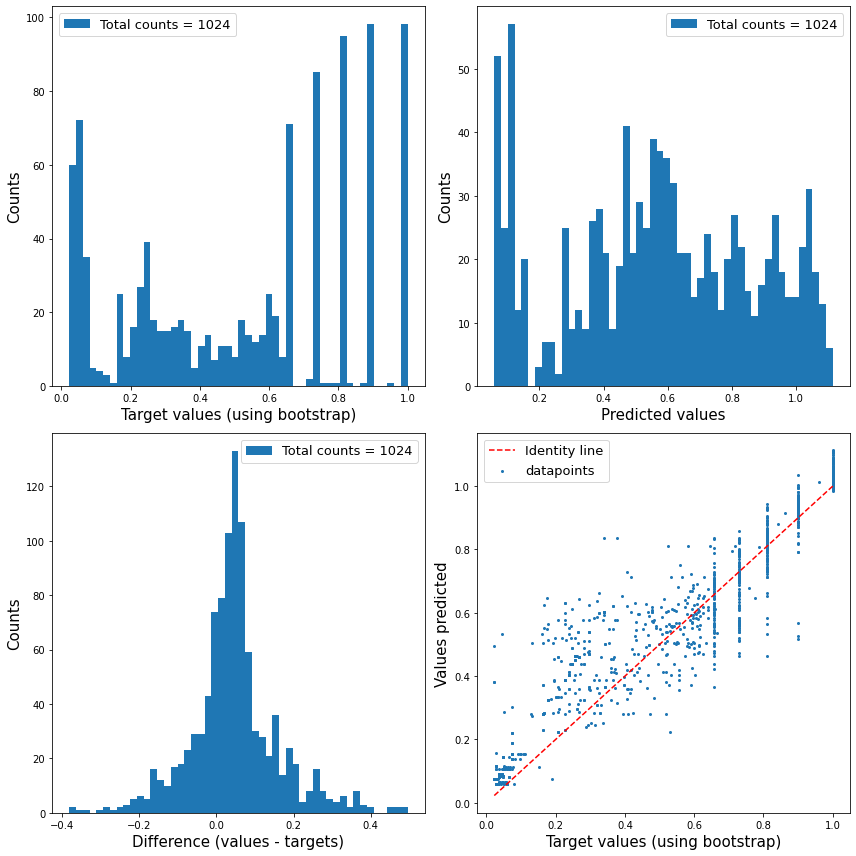

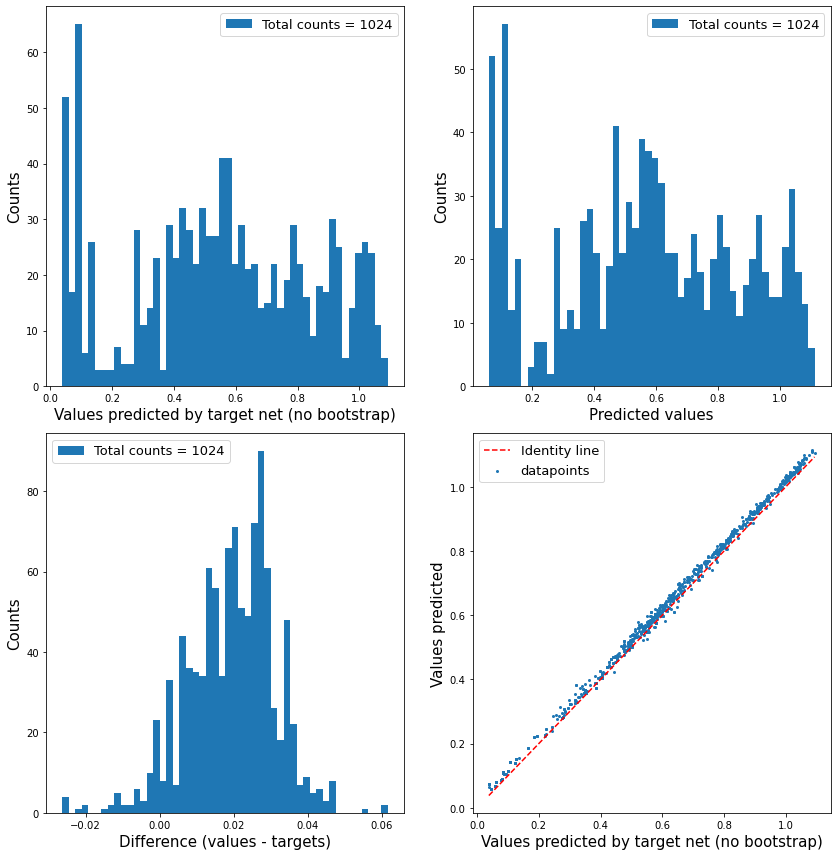

Saved checkpoint.

Episode 801 - Total reward 5
Rollout time: 0.13
Loss: 0.0112

Episode 802 - Total reward 5
Rollout time: 0.13
Loss: 0.0118

Episode 803 - Total reward 4
Rollout time: 0.13
Loss: 0.0119

Episode 804 - Total reward 5
Rollout time: 0.12
Loss: 0.0162

Episode 805 - Total reward 5
Rollout time: 0.13
Loss: 0.0106

Episode 806 - Total reward 5
Rollout time: 0.13
Loss: 0.0125

Episode 807 - Total reward 1
Rollout time: 0.16
Loss: 0.0142

Episode 808 - Total reward 5
Rollout time: 0.13
Loss: 0.0113

Episode 809 - Total reward 3
Rollout time: 0.15
Loss: 0.0132

Episode 810 - Total reward 2
Rollout time: 0.15
Loss: 0.0108

Episode 811 - Total reward 5
Rollout time: 0.12
Loss: 0.0111

Episode 812 - Total reward 3
Rollout time: 0.13
Loss: 0.0108

Episode 813 - Total reward 4
Rollout time: 0.13
Loss: 0.0115

Episode 814 - Total reward 3
Rollout time: 0.14
Loss: 0.0097

Episode 815 - Total reward 4
Rollout time: 0.14
Loss: 0.0128

Episode 816 - Total reward 1
Rollout time: 0.16
Los

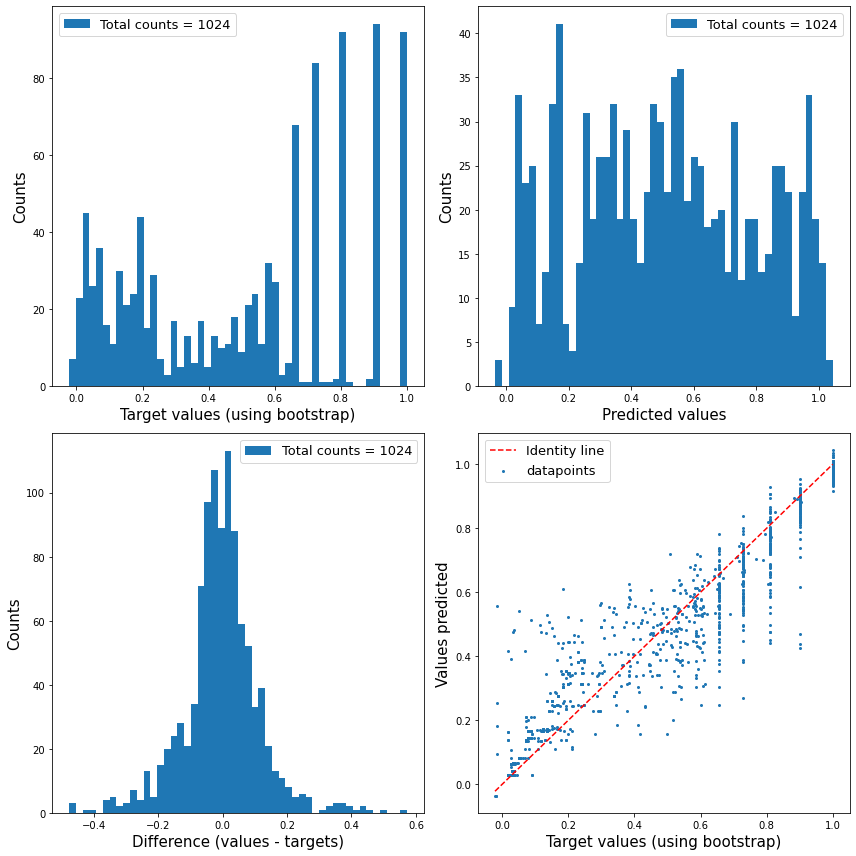

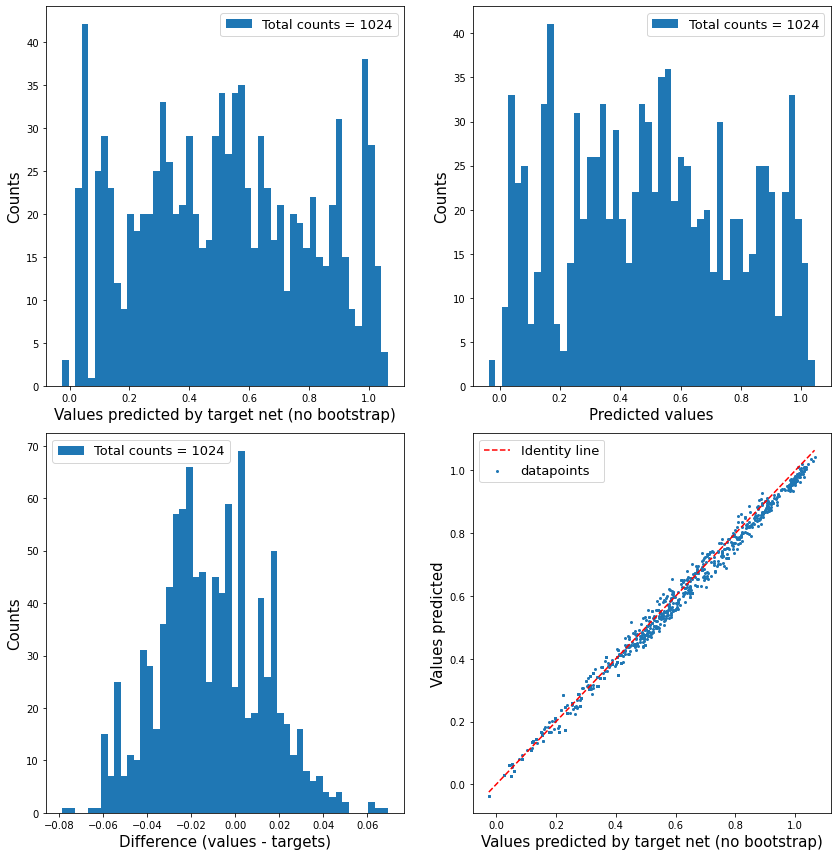

Saved checkpoint.

Episode 901 - Total reward 1
Rollout time: 0.15
Loss: 0.0144

Episode 902 - Total reward 3
Rollout time: 0.14
Loss: 0.0153

Episode 903 - Total reward 2
Rollout time: 0.14
Loss: 0.0131

Episode 904 - Total reward 2
Rollout time: 0.14
Loss: 0.0131

Episode 905 - Total reward 3
Rollout time: 0.14
Loss: 0.0131

Episode 906 - Total reward 7
Rollout time: 0.11
Loss: 0.0120

Episode 907 - Total reward 4
Rollout time: 0.13
Loss: 0.0155

Episode 908 - Total reward 4
Rollout time: 0.13
Loss: 0.0149

Episode 909 - Total reward 3
Rollout time: 0.14
Loss: 0.0155

Episode 910 - Total reward 1
Rollout time: 0.18
Loss: 0.0111

Episode 911 - Total reward 4
Rollout time: 0.13
Loss: 0.0150

Episode 912 - Total reward 4
Rollout time: 0.14
Loss: 0.0167

Episode 913 - Total reward 2
Rollout time: 0.14
Loss: 0.0137

Episode 914 - Total reward 2
Rollout time: 0.14
Loss: 0.0148

Episode 915 - Total reward 5
Rollout time: 0.12
Loss: 0.0110

Episode 916 - Total reward 3
Rollout time: 0.14
Los

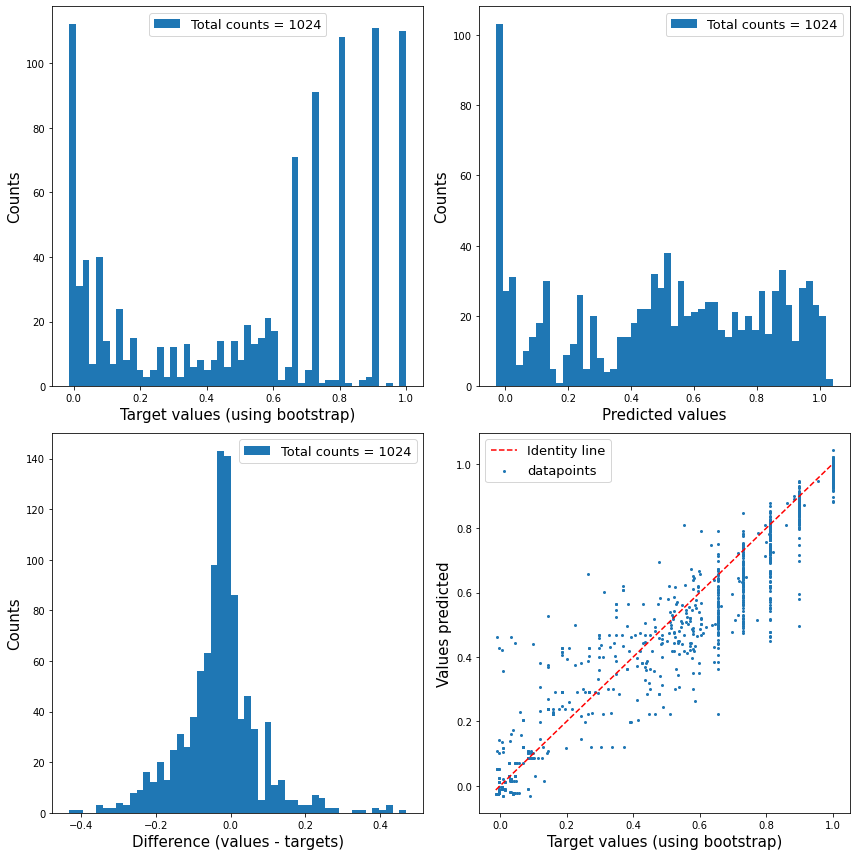

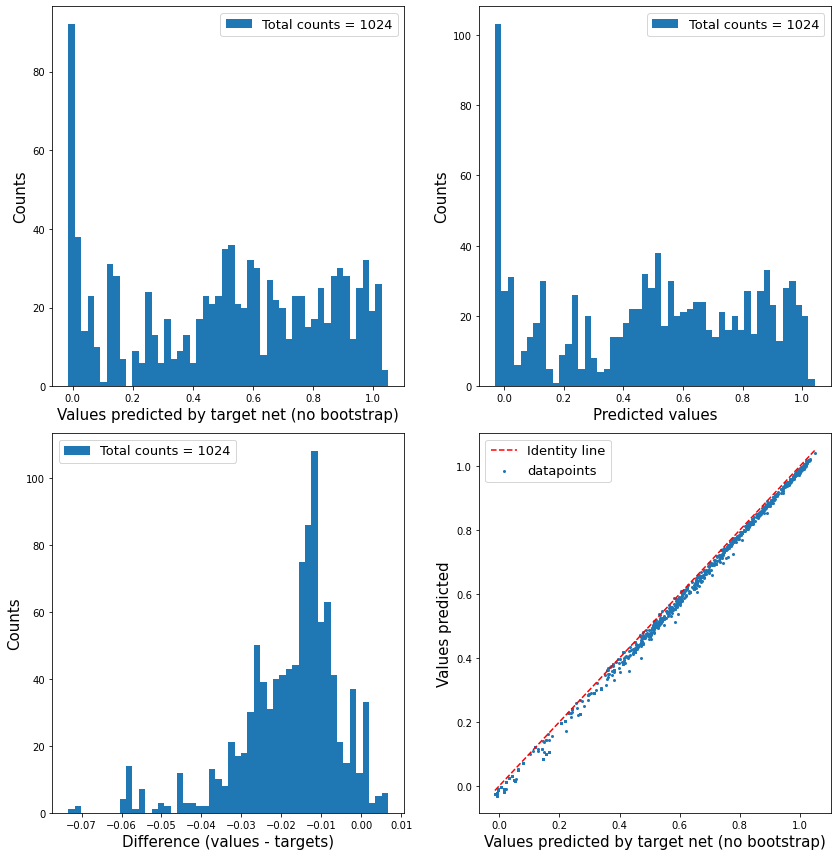

Saved checkpoint.

Episode 1001 - Total reward 2
Rollout time: 0.14
Loss: 0.0144

Episode 1002 - Total reward 3
Rollout time: 0.14
Loss: 0.0107

Episode 1003 - Total reward 2
Rollout time: 0.15
Loss: 0.0123

Episode 1004 - Total reward 5
Rollout time: 0.12
Loss: 0.0136

Episode 1005 - Total reward 4
Rollout time: 0.13
Loss: 0.0160

Episode 1006 - Total reward 3
Rollout time: 0.13
Loss: 0.0138

Episode 1007 - Total reward 4
Rollout time: 0.13
Loss: 0.0118

Episode 1008 - Total reward 1
Rollout time: 0.15
Loss: 0.0125

Episode 1009 - Total reward 5
Rollout time: 0.12
Loss: 0.0110

Episode 1010 - Total reward 3
Rollout time: 0.14
Loss: 0.0136

Episode 1011 - Total reward 4
Rollout time: 0.13
Loss: 0.0152

Episode 1012 - Total reward 1
Rollout time: 0.16
Loss: 0.0129

Episode 1013 - Total reward 2
Rollout time: 0.14
Loss: 0.0124

Episode 1014 - Total reward 6
Rollout time: 0.12
Loss: 0.0112

Episode 1015 - Total reward 3
Rollout time: 0.14
Loss: 0.0111

Episode 1016 - Total reward 3
Rollou

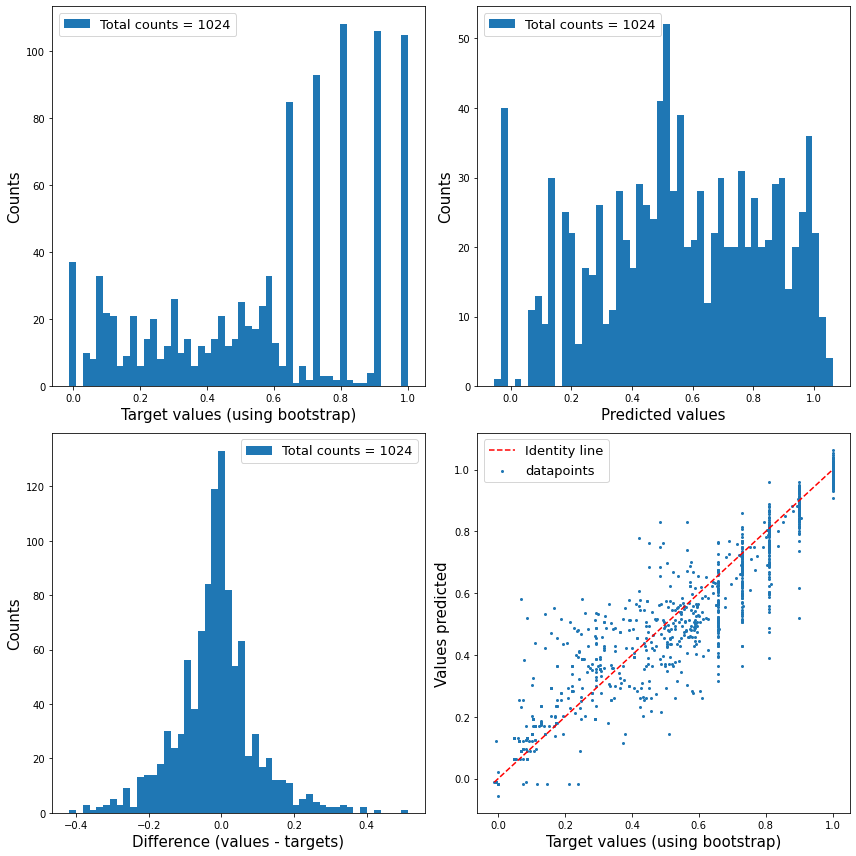

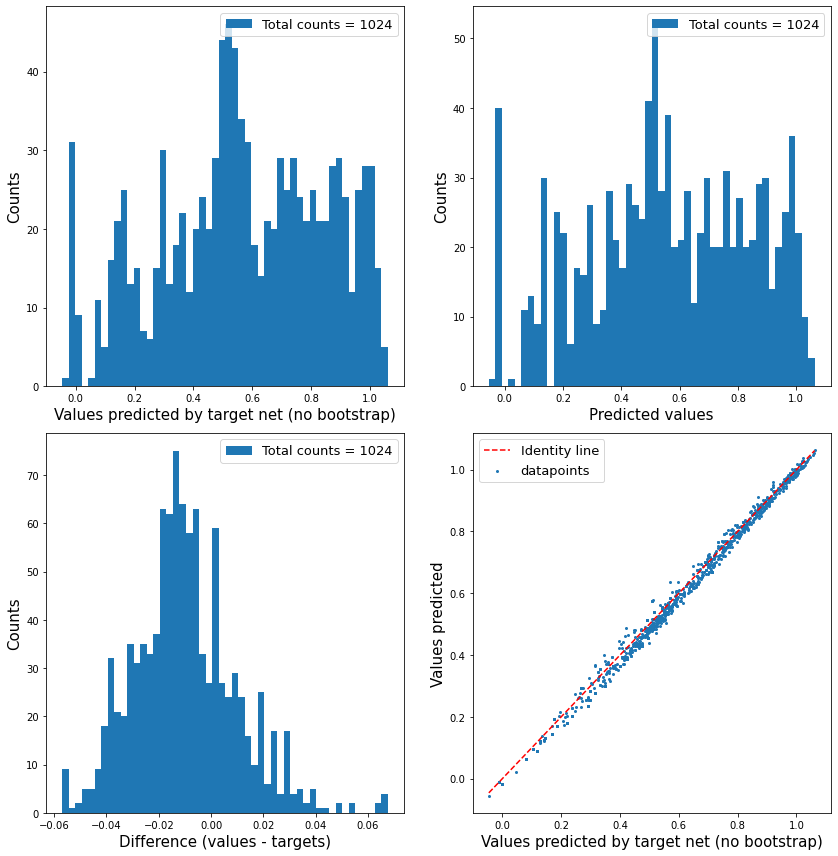

Saved checkpoint.

Episode 1101 - Total reward 3
Rollout time: 0.13
Loss: 0.0108

Episode 1102 - Total reward 5
Rollout time: 0.12
Loss: 0.0126

Episode 1103 - Total reward 3
Rollout time: 0.13
Loss: 0.0134

Episode 1104 - Total reward 5
Rollout time: 0.13
Loss: 0.0119

Episode 1105 - Total reward 3
Rollout time: 0.13
Loss: 0.0116

Episode 1106 - Total reward 3
Rollout time: 0.14
Loss: 0.0128

Episode 1107 - Total reward 5
Rollout time: 0.13
Loss: 0.0139

Episode 1108 - Total reward 3
Rollout time: 0.14
Loss: 0.0116

Episode 1109 - Total reward 1
Rollout time: 0.16
Loss: 0.0135

Episode 1110 - Total reward 2
Rollout time: 0.15
Loss: 0.0130

Episode 1111 - Total reward 4
Rollout time: 0.13
Loss: 0.0124

Episode 1112 - Total reward 4
Rollout time: 0.13
Loss: 0.0145

Episode 1113 - Total reward 6
Rollout time: 0.12
Loss: 0.0135

Episode 1114 - Total reward 5
Rollout time: 0.13
Loss: 0.0117

Episode 1115 - Total reward 3
Rollout time: 0.15
Loss: 0.0129

Episode 1116 - Total reward 2
Rollou

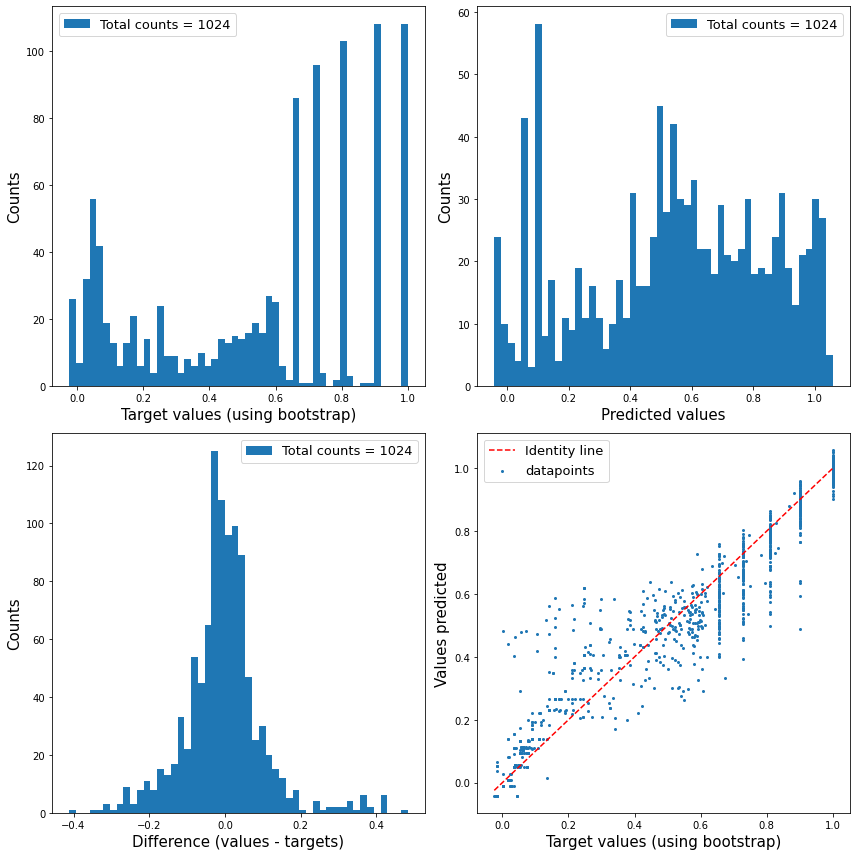

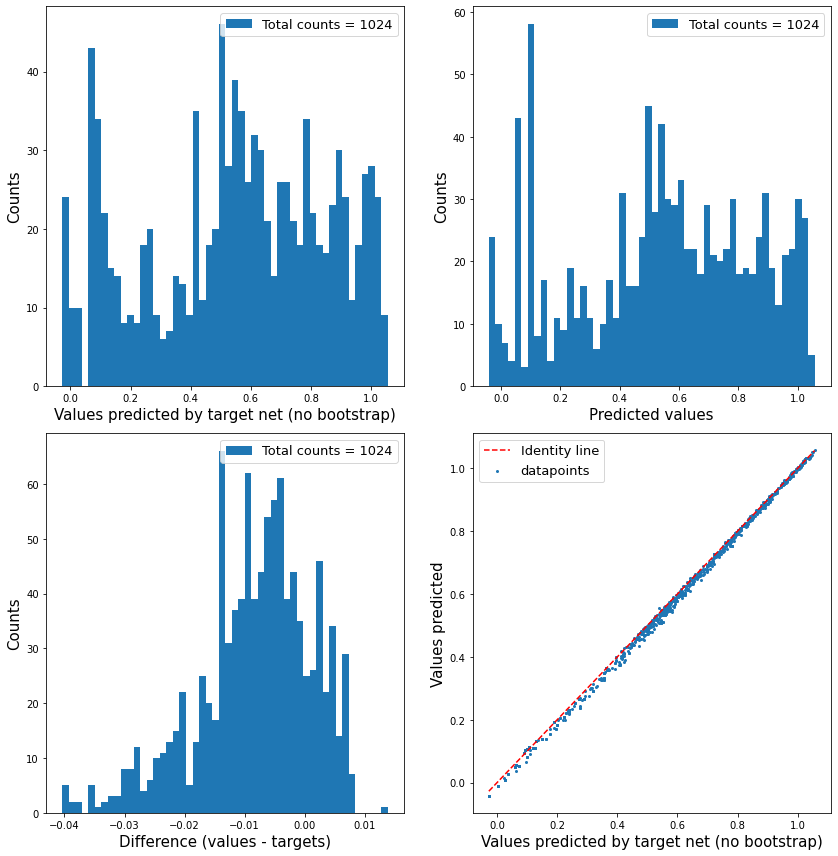

Saved checkpoint.

Episode 1201 - Total reward 0
Rollout time: 0.17
Loss: 0.0128

Episode 1202 - Total reward 2
Rollout time: 0.15
Loss: 0.0153

Episode 1203 - Total reward 3
Rollout time: 0.14
Loss: 0.0138

Episode 1204 - Total reward 5
Rollout time: 0.13
Loss: 0.0132

Episode 1205 - Total reward 7
Rollout time: 0.10
Loss: 0.0112

Episode 1206 - Total reward 5
Rollout time: 0.12
Loss: 0.0106

Episode 1207 - Total reward 2
Rollout time: 0.15
Loss: 0.0161

Episode 1208 - Total reward 1
Rollout time: 0.15
Loss: 0.0141

Episode 1209 - Total reward 3
Rollout time: 0.14
Loss: 0.0112

Episode 1210 - Total reward 6
Rollout time: 0.12
Loss: 0.0136

Episode 1211 - Total reward 4
Rollout time: 0.13
Loss: 0.0136

Episode 1212 - Total reward 4
Rollout time: 0.13
Loss: 0.0125

Episode 1213 - Total reward 2
Rollout time: 0.15
Loss: 0.0121

Episode 1214 - Total reward 3
Rollout time: 0.13
Loss: 0.0143

Episode 1215 - Total reward 4
Rollout time: 0.13
Loss: 0.0123

Episode 1216 - Total reward 4
Rollou

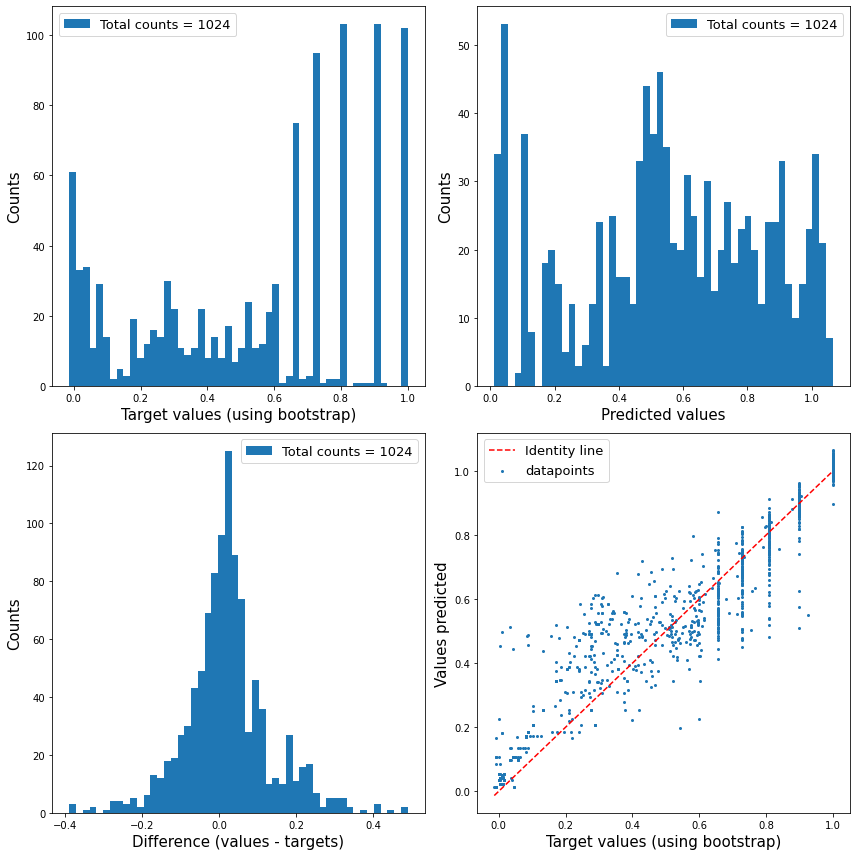

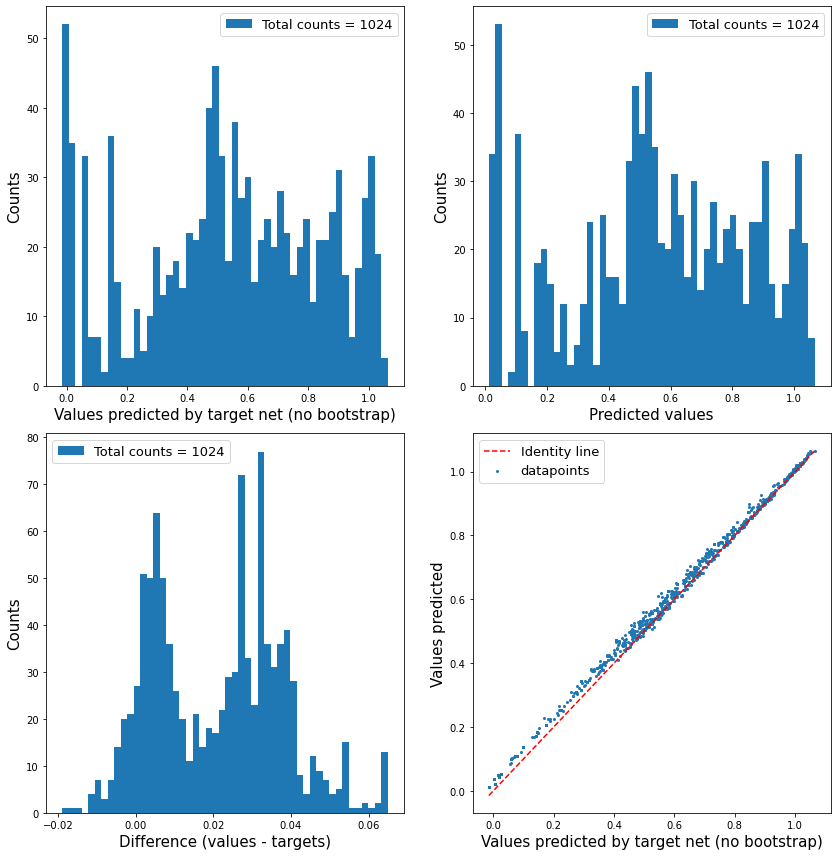

Saved checkpoint.

Episode 1301 - Total reward 4
Rollout time: 0.13
Loss: 0.0132

Episode 1302 - Total reward 5
Rollout time: 0.12
Loss: 0.0112

Episode 1303 - Total reward 4
Rollout time: 0.13
Loss: 0.0138

Episode 1304 - Total reward 5
Rollout time: 0.12
Loss: 0.0132

Episode 1305 - Total reward 0
Rollout time: 0.17
Loss: 0.0140

Episode 1306 - Total reward 5
Rollout time: 0.13
Loss: 0.0121

Episode 1307 - Total reward 4
Rollout time: 0.13
Loss: 0.0123

Episode 1308 - Total reward 1
Rollout time: 0.16
Loss: 0.0122

Episode 1309 - Total reward 6
Rollout time: 0.12
Loss: 0.0133

Episode 1310 - Total reward 6
Rollout time: 0.12
Loss: 0.0116

Episode 1311 - Total reward 2
Rollout time: 0.15
Loss: 0.0136

Episode 1312 - Total reward 4
Rollout time: 0.13
Loss: 0.0123

Episode 1313 - Total reward 4
Rollout time: 0.13
Loss: 0.0132

Episode 1314 - Total reward 3
Rollout time: 0.14
Loss: 0.0115

Episode 1315 - Total reward 0
Rollout time: 0.17
Loss: 0.0113

Episode 1316 - Total reward 4
Rollou

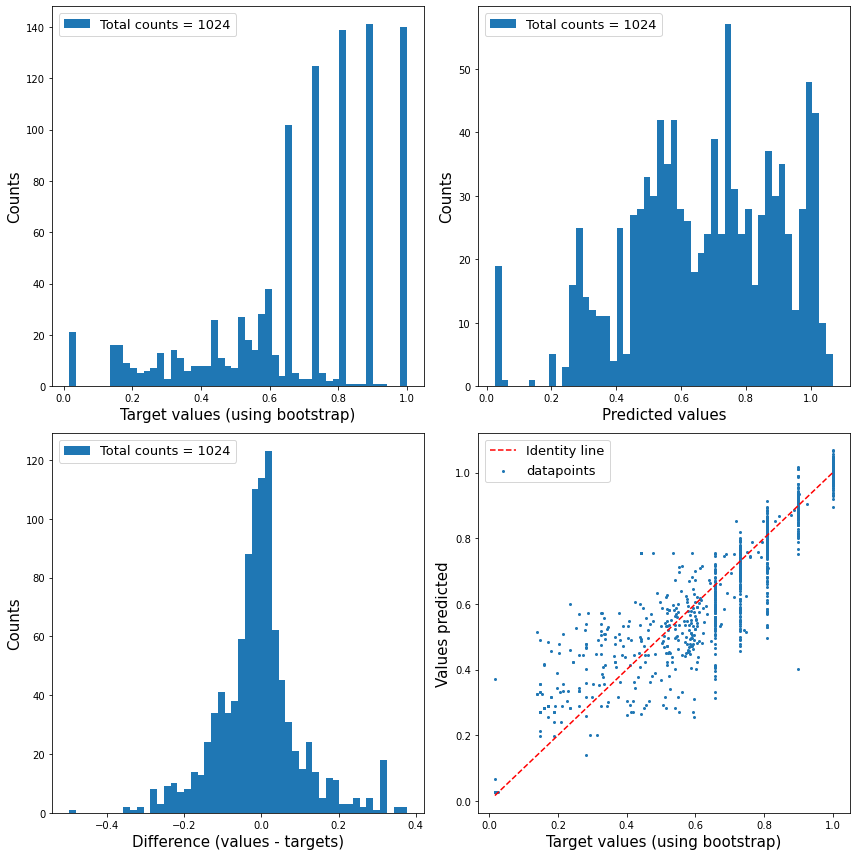

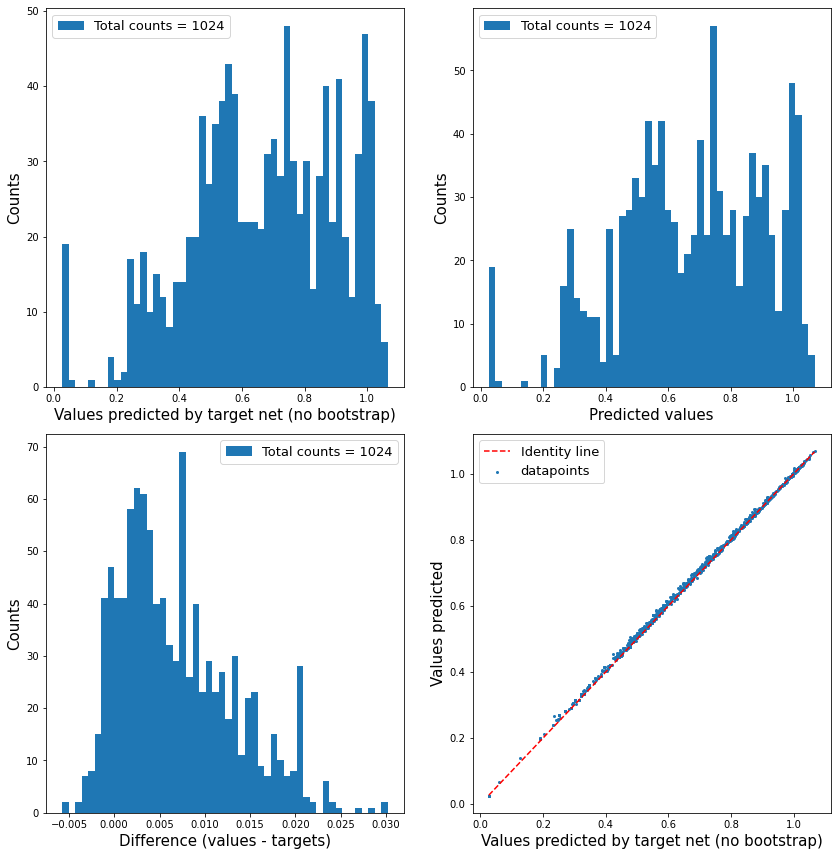

Saved checkpoint.

Episode 1401 - Total reward 1
Rollout time: 0.16
Loss: 0.0130

Episode 1402 - Total reward 3
Rollout time: 0.14
Loss: 0.0135

Episode 1403 - Total reward 5
Rollout time: 0.13
Loss: 0.0122

Episode 1404 - Total reward 5
Rollout time: 0.12
Loss: 0.0149

Episode 1405 - Total reward 5
Rollout time: 0.12
Loss: 0.0131

Episode 1406 - Total reward 4
Rollout time: 0.13
Loss: 0.0106

Episode 1407 - Total reward 4
Rollout time: 0.13
Loss: 0.0123

Episode 1408 - Total reward 4
Rollout time: 0.12
Loss: 0.0112

Episode 1409 - Total reward 3
Rollout time: 0.14
Loss: 0.0099

Episode 1410 - Total reward 4
Rollout time: 0.14
Loss: 0.0123

Episode 1411 - Total reward 4
Rollout time: 0.13
Loss: 0.0135

Episode 1412 - Total reward 3
Rollout time: 0.14
Loss: 0.0113

Episode 1413 - Total reward 5
Rollout time: 0.12
Loss: 0.0125

Episode 1414 - Total reward 1
Rollout time: 0.15
Loss: 0.0127

Episode 1415 - Total reward 2
Rollout time: 0.14
Loss: 0.0119

Episode 1416 - Total reward 5
Rollou

In [ ]:
%%time
total_rewards = []
losses = []
for i in range(n_episodes):
    ### Generate experience ###
    t0 = time.time()
    #modes = ["simulate", "predict", "simulate_and_predict"]
    modes=["predict"]
    mode = np.random.choice(modes)
    value_net.eval()
    total_reward, frame_lst, reward_lst, done_lst = train.play_rollout_value_net(value_net,
                                                                                game_simulator,
                                                                                episode_length,
                                                                                ucb_C,
                                                                                discount,
                                                                                max_actions,
                                                                                num_simulations,
                                                                                mode=mode,
                                                                                bootstrap="no"
                                                                                )
    t1 = time.time()
    total_rewards.append(total_reward)
    print("\nEpisode %d - Total reward %d"%(i+1, total_reward))
    rollout_time = (t1-t0)/60
    print("Rollout time: %.2f"%(rollout_time))
    rb.store_episode(frame_lst, reward_lst, done_lst)
    
    ### Train value_net ###

    try:
        # update value network all the time
        target_net.eval()
        frames, targets = rb.get_batch(batch_size, n_steps, discount, target_net, device)
        value_net.train()
        loss = train.compute_update_v1(value_net, frames, targets, loss_fn, optimizer)
        scheduler.step()
        # update target network only from time to time
        if (i+1)%8==0:
            train.update_target_net(target_net, value_net, tau)
        print("Loss: %.4f"%loss)
        losses.append(loss)

    except:
        pass

    if (i+1)%50==0:
        # Print update
        print("\nAverage reward over last 50 rollouts: %.2f\n"%(np.mean(total_rewards[-50:])))
        
    if (i+1)%100==0:
        # Plot histograms of value stats and save checkpoint
        target_net.eval()
        value_net.eval()
        
        train.plot_value_stats(value_net, target_net, rb, batch_size, n_steps, discount, device)
        
        d = dict(
            episodes_played=i,
            training_params=training_params,
            object_ids=object_ids,
            value_net=value_net,
            target_net=target_net,
            rb=rb,
            losses=losses,
            total_rewards=total_rewards
        )

        if not os.path.isdir('./save_dir/'+ID+'/'):
            os.mkdir('./save_dir/'+ID+'/')
        torch.save(d, './save_dir/'+ID+'/training_dict_%d'%(i+1))
        print("Saved checkpoint.")

## How to save everything for later analysis

In [3]:
frame, _ = game_simulator.reset()
game_simulator.render()


██████
█ ?  █
█n   █
█ y  █
█ !@ █
██████



In [4]:
f1 = frame['name'][0,:,:,0,0]
f1

tensor([[  3,   3,   3,   3,   3,   3],
        [  3, 170, 180, 170, 170,   3],
        [  3, 198, 170, 170, 170,   3],
        [  3, 170, 200, 170, 170,   3],
        [  3, 170, 179, 183, 170,   3],
        [  3,   3,   3,   3,   3,   3]])

In [5]:
object_ids = dict(
    target_monster = 179,
    yes_item = 200,
    distractor_monster = 180,
    agent = 183,
    no_item = 198
    )

object_ids

{'target_monster': 179,
 'yes_item': 200,
 'distractor_monster': 180,
 'agent': 183,
 'no_item': 198}

In [8]:
save=False
d = dict(
    object_ids=object_ids,
    value_net=value_net,
    target_net=target_net,
    rb=rb,
    losses=losses
)
if save:
    torch.save(d, "saved/training_dict_n_steps_boot_100simul")

## Evaluate with more episodes and see if more frequent updates could be beneficial

In [11]:
%%time
# More thourough test at the end to compare the 4 
num_simulations = 50
scores = mcts.compare_modes(game_simulator, 
                               value_net, 
                               episode_length, 
                               ucb_C, 
                               discount, 
                               max_actions, 
                               num_simulations,
                               n_episodes=100
                              )
print("Average return in simulate mode: ", scores[0])
print("Average return in predict mode: ", scores[1])
print("Average return in simulate and predict mode: ", scores[2])
print("Average return in hybrid mode: ", scores[3])


Mode: simulate

██████
█y  @█
█ !  █
█n   █
█ ?  █
██████


██████
█y  @█
█ !  █
█n   █
█ ?  █
██████


██████
█y  @█
█ !  █
█n   █
█ ?  █
██████


██████
█y  @█
█ !  █
█n   █
█ ?  █
██████


██████
█y  @█
█ !  █
█n   █
█ ?  █
██████


██████
█y  @█
█ !  █
█n   █
█ ?  █
██████


██████
█y  @█
█ !  █
█n   █
█ ?  █
██████


██████
█y   █
█ ! @█
█n   █
█ ?  █
██████


██████
█y  @█
█ !  █
█n   █
█ ?  █
██████


██████
█y  @█
█ !  █
█n   █
█ ?  █
██████


██████
█y  @█
█ !  █
█n   █
█ ?  █
██████


██████
█y  @█
█ !  █
█n   █
█ ?  █
██████


██████
█y  @█
█ !  █
█n   █
█ ?  █
██████


██████
█y   █
█ ! @█
█n   █
█ ?  █
██████


██████
█y   █
█ !  █
█n  @█
█ ?  █
██████


██████
█y   █
█ ! @█
█n   █
█ ?  █
██████


██████
█y  @█
█ !  █
█n   █
█ ?  █
██████


Mode: predict

██████
█y  @█
█ !  █
█n   █
█ ?  █
██████


██████
█y   █
█ ! @█
█n   █
█ ?  █
██████


██████
█y   █
█ !  █
█n  @█
█ ?  █
██████


██████
█y   █
█ !  █
█n  @█
█ ?  █
██████


██████
█y   █
█ ! @█
█n   █
█ ?  █
██████




In [11]:
# Let's see if more updates on the value net given the current experience are beneficial
n_updates = 1000
losses = []
for i in range(n_updates):
    frames, targets = rb.get_batch(64)
    reshaped_frames = {}
    for k in frames.keys():
        shape = frames[k].shape
        reshaped_frames[k] = frames[k].reshape(-1,*shape[2:])
    targets = targets.reshape(-1).to(device)
    values = value_net(reshaped_frames).squeeze(1)
    
    loss = loss_fn(values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print("Update: %d - Loss: %.4f"%(i+1,loss.item()))
    losses.append(loss.item())

Update: 1 - Loss: 0.0382
Update: 2 - Loss: 0.0195
Update: 3 - Loss: 0.0222
Update: 4 - Loss: 0.0180
Update: 5 - Loss: 0.0230
Update: 6 - Loss: 0.0239
Update: 7 - Loss: 0.0223
Update: 8 - Loss: 0.0193
Update: 9 - Loss: 0.0179
Update: 10 - Loss: 0.0153
Update: 11 - Loss: 0.0176
Update: 12 - Loss: 0.0216
Update: 13 - Loss: 0.0185
Update: 14 - Loss: 0.0207
Update: 15 - Loss: 0.0207
Update: 16 - Loss: 0.0156
Update: 17 - Loss: 0.0191
Update: 18 - Loss: 0.0181
Update: 19 - Loss: 0.0113
Update: 20 - Loss: 0.0271
Update: 21 - Loss: 0.0203
Update: 22 - Loss: 0.0217
Update: 23 - Loss: 0.0211
Update: 24 - Loss: 0.0205
Update: 25 - Loss: 0.0185
Update: 26 - Loss: 0.0231
Update: 27 - Loss: 0.0134
Update: 28 - Loss: 0.0129
Update: 29 - Loss: 0.0143
Update: 30 - Loss: 0.0177
Update: 31 - Loss: 0.0214
Update: 32 - Loss: 0.0134
Update: 33 - Loss: 0.0208
Update: 34 - Loss: 0.0150
Update: 35 - Loss: 0.0131
Update: 36 - Loss: 0.0125
Update: 37 - Loss: 0.0156
Update: 38 - Loss: 0.0120
Update: 39 - Loss: 0.

Update: 319 - Loss: 0.0032
Update: 320 - Loss: 0.0056
Update: 321 - Loss: 0.0042
Update: 322 - Loss: 0.0034
Update: 323 - Loss: 0.0030
Update: 324 - Loss: 0.0038
Update: 325 - Loss: 0.0045
Update: 326 - Loss: 0.0028
Update: 327 - Loss: 0.0027
Update: 328 - Loss: 0.0022
Update: 329 - Loss: 0.0049
Update: 330 - Loss: 0.0029
Update: 331 - Loss: 0.0037
Update: 332 - Loss: 0.0023
Update: 333 - Loss: 0.0033
Update: 334 - Loss: 0.0035
Update: 335 - Loss: 0.0039
Update: 336 - Loss: 0.0037
Update: 337 - Loss: 0.0028
Update: 338 - Loss: 0.0040
Update: 339 - Loss: 0.0029
Update: 340 - Loss: 0.0040
Update: 341 - Loss: 0.0041
Update: 342 - Loss: 0.0058
Update: 343 - Loss: 0.0041
Update: 344 - Loss: 0.0041
Update: 345 - Loss: 0.0073
Update: 346 - Loss: 0.0046
Update: 347 - Loss: 0.0031
Update: 348 - Loss: 0.0059
Update: 349 - Loss: 0.0039
Update: 350 - Loss: 0.0051
Update: 351 - Loss: 0.0044
Update: 352 - Loss: 0.0051
Update: 353 - Loss: 0.0043
Update: 354 - Loss: 0.0048
Update: 355 - Loss: 0.0027
U

Update: 627 - Loss: 0.0019
Update: 628 - Loss: 0.0031
Update: 629 - Loss: 0.0024
Update: 630 - Loss: 0.0022
Update: 631 - Loss: 0.0018
Update: 632 - Loss: 0.0021
Update: 633 - Loss: 0.0032
Update: 634 - Loss: 0.0044
Update: 635 - Loss: 0.0016
Update: 636 - Loss: 0.0035
Update: 637 - Loss: 0.0048
Update: 638 - Loss: 0.0028
Update: 639 - Loss: 0.0032
Update: 640 - Loss: 0.0021
Update: 641 - Loss: 0.0024
Update: 642 - Loss: 0.0015
Update: 643 - Loss: 0.0020
Update: 644 - Loss: 0.0021
Update: 645 - Loss: 0.0029
Update: 646 - Loss: 0.0028
Update: 647 - Loss: 0.0025
Update: 648 - Loss: 0.0021
Update: 649 - Loss: 0.0019
Update: 650 - Loss: 0.0028
Update: 651 - Loss: 0.0023
Update: 652 - Loss: 0.0016
Update: 653 - Loss: 0.0024
Update: 654 - Loss: 0.0036
Update: 655 - Loss: 0.0016
Update: 656 - Loss: 0.0020
Update: 657 - Loss: 0.0031
Update: 658 - Loss: 0.0025
Update: 659 - Loss: 0.0033
Update: 660 - Loss: 0.0025
Update: 661 - Loss: 0.0024
Update: 662 - Loss: 0.0024
Update: 663 - Loss: 0.0027
U

Update: 935 - Loss: 0.0057
Update: 936 - Loss: 0.0046
Update: 937 - Loss: 0.0067
Update: 938 - Loss: 0.0038
Update: 939 - Loss: 0.0048
Update: 940 - Loss: 0.0052
Update: 941 - Loss: 0.0050
Update: 942 - Loss: 0.0064
Update: 943 - Loss: 0.0033
Update: 944 - Loss: 0.0064
Update: 945 - Loss: 0.0052
Update: 946 - Loss: 0.0071
Update: 947 - Loss: 0.0035
Update: 948 - Loss: 0.0030
Update: 949 - Loss: 0.0055
Update: 950 - Loss: 0.0046
Update: 951 - Loss: 0.0057
Update: 952 - Loss: 0.0035
Update: 953 - Loss: 0.0034
Update: 954 - Loss: 0.0034
Update: 955 - Loss: 0.0031
Update: 956 - Loss: 0.0088
Update: 957 - Loss: 0.0072
Update: 958 - Loss: 0.0028
Update: 959 - Loss: 0.0035
Update: 960 - Loss: 0.0036
Update: 961 - Loss: 0.0039
Update: 962 - Loss: 0.0064
Update: 963 - Loss: 0.0037
Update: 964 - Loss: 0.0028
Update: 965 - Loss: 0.0062
Update: 966 - Loss: 0.0037
Update: 967 - Loss: 0.0052
Update: 968 - Loss: 0.0042
Update: 969 - Loss: 0.0049
Update: 970 - Loss: 0.0032
Update: 971 - Loss: 0.0053
U

In [22]:
if save:
    torch.save(value_net, "value_net_overfitted")

In [12]:
%%time
scores = mcts.compare_modes(game_simulator, 
                               value_net, 
                               episode_length, 
                               ucb_C, 
                               discount, 
                               max_actions, 
                               num_simulations,
                               n_episodes=100
                              )
print("Average return in simulate mode: ", scores[0])
print("Average return in predict mode: ", scores[1])
print("Average return in simulate and predict mode: ", scores[2])
print("Average return in hybrid mode: ", scores[3])


Mode: simulate

██████
█   @█
█   y█
█   ?█
█n  !█
██████


██████
█  @ █
█   y█
█   ?█
█n  !█
██████


██████
█   @█
█   y█
█   ?█
█n  !█
██████


██████
█    █
█   @█
█   ?█
█n  !█
██████
blessed sword

██████
█    █
█  @ █
█   ?█
█n  !█
██████
blessed sword

██████
█    █
█    █
█  @?█
█n  !█
██████
blessed sword

██████
█    █
█    █
█   ?█
█n @!█
██████
blessed sword

██████
█    █
█    █
█   ?█
█n  @█
██████
blessed sword

Mode: predict

██████
█   @█
█   y█
█   ?█
█n  !█
██████


██████
█  @ █
█   y█
█   ?█
█n  !█
██████


██████
█  @ █
█   y█
█   ?█
█n  !█
██████


██████
█  @ █
█   y█
█   ?█
█n  !█
██████


██████
█   @█
█   y█
█   ?█
█n  !█
██████


██████
█  @ █
█   y█
█   ?█
█n  !█
██████


██████
█  @ █
█   y█
█   ?█
█n  !█
██████


██████
█  @ █
█   y█
█   ?█
█n  !█
██████


██████
█  @ █
█   y█
█   ?█
█n  !█
██████


██████
█   @█
█   y█
█   ?█
█n  !█
██████


██████
█    █
█   @█
█   ?█
█n  !█
██████
blessed sword

██████
█   @█
█    █
█   ?█
█n  !█
██████
blessed swor

## Show some metrics saved during training
Use Value_debug notebook for a more in depth analysis.

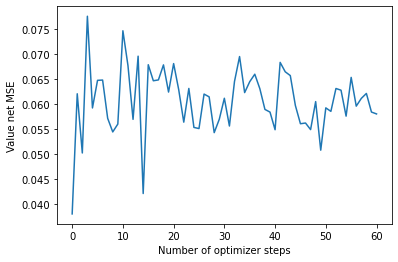

In [8]:
plt.plot(np.arange(len(losses)), losses)
plt.xlabel("Number of optimizer steps")
plt.ylabel("Value net MSE")
plt.show()

In [9]:
simulate_scores = [score[0] for score in mode_scores] 
predict_scores = [score[1] for score in mode_scores]
sim_and_pred_scores = [score[2] for score in mode_scores] 
hybrid_scores = [score[3] for score in mode_scores] 

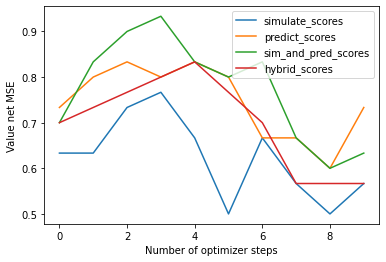

In [10]:
plt.plot(np.arange(len(mode_scores)), simulate_scores, label="simulate_scores")
plt.plot(np.arange(len(mode_scores)), predict_scores, label="predict_scores")
plt.plot(np.arange(len(mode_scores)), sim_and_pred_scores, label="sim_and_pred_scores")
plt.plot(np.arange(len(mode_scores)), hybrid_scores, label="hybrid_scores")
plt.legend()
plt.xlabel("Number of optimizer steps")
plt.ylabel("Value net MSE")
plt.show()

## Tests

1) **Average performance** using predict mode with different **number of simulations** for the MCTS. This should answer to the question "Do more simulation improve the predict method?". I expect it to do so, as it does in the "simulate" method (a.k.a. standard MCTS). If that is not the case there is something fundamentally wrong with the value network in the MCTS. As an extra we can compare the increase in performance using the value net with the one using the simulation instead and see how is the improvment curve there.

2) Selecting the node based on the **highest visit count vs the highest Q-value**. Let's use the same IC while doing so. Answer: Q-value is way better (0.47 vs -0.27).

3) New method for estimating the value of a node: **0.5 x simulate + 0.5 x predict**. Is it going to be better than simulate? Answer: not with current network, even though is better than predict. (simulate = 0.94, predict = 0.32 , simulate n-steps and then predict = 0.57, 0.5 x simulate + 0.5 x predict = 0.84)

4) Test **different architectures** on some data collected by a standard MCTS and see if we can improve the performance of a ValueMCTS (evaluated with a method that uses the value net) in order to surpass the standard MCTS performance. - still to come up with better architecture

5) Discrete support set for value prediction. Is it going to help? Answer: no, training "offline" on a given set of experience, the average reward for episode is 0.25 vs 0.5 of the standard valueMCTS.

6) Is the accuracy of the value network correlated with the performance? Try to compare it to a randomly initialized network (same architecture) and see the difference. Answer: yes, the ValueMCTS with trained network is better than the one with untrained network (0.41 vs 0.27).

### Test 1

In [3]:
value_net = torch.load("value_net_boot")

In [4]:
def num_simulation_test(value_net, env_simulator, test_episodes=100):
    num_simulations = [5,10,20,50,100]
    average_performance = []
    for n in num_simulations:
        print("Evaluating policy with %d simulations per step..."%n)
        score = 0
        for i in range(test_episodes): # test on 'test_episodes' episodes
            if i ==0:
                render=True
            else:
                render=False
            total_reward, _, _ , _ = mcts.play_episode_value_net(value_net, env_simulator, episode_length, ucb_C, 
                                                            discount, max_actions, n, mode="predict", render=render)
            score += total_reward
        score = score/test_episodes
        print("Average performance using %d simulations per step: %.2f"%(n, score))
        average_performance.append(score)
    return num_simulations, average_performance

In [5]:
num_simulations, average_performance = num_simulation_test(value_net, game_simulator, test_episodes=100)

Evaluating policy with 5 simulations per step...

██████
█    █
█ @y █
█ !  █
█n ? █
██████


██████
█    █
█  @ █
█ !  █
█n ? █
██████
grandmasters sword

██████
█    █
█  @ █
█ !  █
█n ? █
██████
grandmasters sword

██████
█    █
█  @ █
█ !  █
█n ? █
██████
grandmasters sword

██████
█    █
█  @ █
█ !  █
█n ? █
██████
grandmasters sword

██████
█    █
█  @ █
█ !  █
█n ? █
██████
grandmasters sword

██████
█    █
█  @ █
█ !  █
█n ? █
██████
grandmasters sword

██████
█    █
█  @ █
█ !  █
█n ? █
██████
grandmasters sword

██████
█    █
█  @ █
█ !  █
█n ? █
██████
grandmasters sword

██████
█    █
█  @ █
█ !  █
█n ? █
██████
grandmasters sword

██████
█    █
█  @ █
█ !  █
█n ? █
██████
grandmasters sword

██████
█    █
█  @ █
█ !  █
█n ? █
██████
grandmasters sword

██████
█    █
█  @ █
█ !  █
█n ? █
██████
grandmasters sword

██████
█    █
█  @ █
█ !  █
█n ? █
██████
grandmasters sword

██████
█    █
█  @ █
█ !  █
█n ? █
██████
grandmasters sword

██████
█    █
█  @ █
█ !  █
█n ? █
███

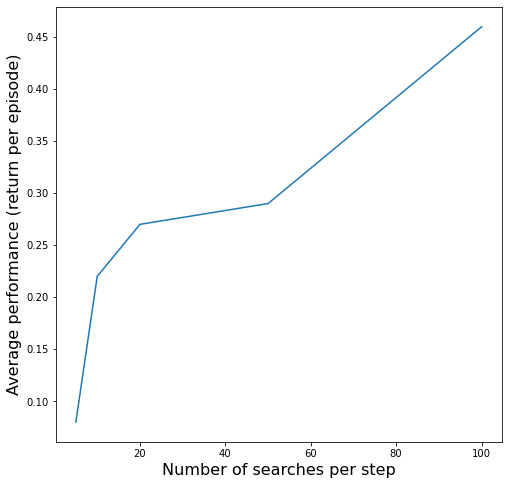

In [6]:
plt.figure(figsize=(8,8))
plt.plot(num_simulations, average_performance)
plt.xlabel("Number of searches per step", fontsize=16)
plt.ylabel("Average performance (return per episode)", fontsize=16)
plt.show()

### Test 1 - Bis

Study performance of standard MCTS depending on num simulations and max actions

In [22]:
ucb_C = 1.0
discount = 0.997
episode_length = 32
device = mcts.device

flags = utils.Flags(env="rtfm:groups_simple_stationary-v0")
gym_env = utils.create_env(flags)
featurizer = X.Render()
game_simulator = mcts.FullTrueSimulator(gym_env, featurizer)
value_net = mcts.ValueMLP(gym_env).to(device) # doesn't really matter

n_features:  1460


In [23]:
num_simulations = [5,10,20,50,100]
actions = [5,10,20,50]
test_episodes = 200 # change it to 100 at least
results = {}
times = {}
for n in num_simulations:
    for max_actions in actions:
        print("Evaluating policy with %d simulations per step and %d actions per rollout"%(n,max_actions))
        start = time.time()
        score = 0
        for i in range(test_episodes): # test on 'test_episodes' episodes
            if i ==0:
                render=True
            else:
                render=False
            total_reward, _, _ , _ = train.play_episode_value_net(value_net, game_simulator, episode_length, ucb_C, 
                                                            discount, max_actions, n, mode="simulate", render=render)
            score += total_reward
        score = score/test_episodes
        print("Average performance using %d simulations per step and %d actions per rollout: %.2f"%(n, max_actions, score))
        elapsed = (time.time() - start)/60 # in minutes
        results[(n, max_actions)] = score
        times[(n, max_actions)] = elapsed
        
MCTS_benchmark = {"results":results, "times":times}
torch.save(MCTS_benchmark, "./save_dir/MCTS_benchmark")

Evaluating policy with 5 simulations per step and 5 actions per rollout

██████
█  n █
█  ! █
█? @ █
█   y█
██████


██████
█  n █
█  ! █
█?   █
█  @y█
██████


██████
█  n █
█  ! █
█?   █
█  @y█
██████


██████
█  n █
█  ! █
█?   █
█  @y█
██████


██████
█  n █
█  ! █
█?   █
█   @█
██████
blessed sword

██████
█  n █
█  ! █
█?   █
█  @ █
██████
blessed sword

██████
█  n █
█  ! █
█? @ █
█    █
██████
blessed sword

██████
█  n █
█  @ █
█?   █
█    █
██████
blessed sword
Average performance using 5 simulations per step and 5 actions per rollout: 0.65
Evaluating policy with 5 simulations per step and 10 actions per rollout

██████
█!  ?█
█ ny █
█    █
█ @  █
██████


██████
█!  ?█
█ ny █
█    █
█  @ █
██████


██████
█!  ?█
█ ny █
█    █
█   @█
██████


██████
█!  ?█
█ ny █
█    █
█  @ █
██████


██████
█!  ?█
█ ny █
█  @ █
█    █
██████


██████
█!  ?█
█ ny █
█   @█
█    █
██████


██████
█!  ?█
█ ny █
█   @█
█    █
██████


██████
█!  ?█
█ ny █
█   @█
█    █
██████


██████
█!  ?█
█ n


██████
█   !█
█    █
█ @  █
█  ? █
██████
gleaming sword

██████
█   !█
█    █
█@   █
█  ? █
██████
gleaming sword

██████
█   !█
█    █
█@   █
█  ? █
██████
gleaming sword

██████
█   !█
█@   █
█    █
█  ? █
██████
gleaming sword

██████
█   !█
█    █
█@   █
█  ? █
██████
gleaming sword

██████
█   !█
█@   █
█    █
█  ? █
██████
gleaming sword

██████
█   !█
█@   █
█    █
█  ? █
██████
gleaming sword

██████
█   !█
█@   █
█    █
█  ? █
██████
gleaming sword

██████
█   !█
█@   █
█    █
█  ? █
██████
gleaming sword

██████
█   !█
█@   █
█    █
█  ? █
██████
gleaming sword

██████
█   !█
█@   █
█    █
█  ? █
██████
gleaming sword

██████
█   !█
█@   █
█    █
█  ? █
██████
gleaming sword

██████
█@  !█
█    █
█    █
█  ? █
██████
gleaming sword

██████
█ @ !█
█    █
█    █
█  ? █
██████
gleaming sword

██████
█@  !█
█    █
█    █
█  ? █
██████
gleaming sword

██████
█@  !█
█    █
█    █
█  ? █
██████
gleaming sword

██████
█   !█
█@   █
█    █
█  ? █
██████
gleaming sword

██████
█@  !█


██████
█n !y█
█    █
█ ?  █
█  @ █
██████


██████
█n !y█
█    █
█ ?  █
█   @█
██████


██████
█n !y█
█    █
█ ? @█
█    █
██████


██████
█n !y█
█   @█
█ ?  █
█    █
██████


██████
█n !@█
█    █
█ ?  █
█    █
██████
blessed sword

██████
█n @ █
█    █
█ ?  █
█    █
██████
blessed sword
Average performance using 100 simulations per step and 50 actions per rollout: 0.99


In [28]:
benchmark = torch.load("./save_dir/MCTS_benchmark")

In [29]:
results = benchmark["results"]

In [30]:
results

{(5, 5): 0.645,
 (5, 10): 0.705,
 (5, 20): 0.7,
 (5, 50): 0.75,
 (10, 5): 0.635,
 (10, 10): 0.745,
 (10, 20): 0.825,
 (10, 50): 0.815,
 (20, 5): 0.635,
 (20, 10): 0.78,
 (20, 20): 0.89,
 (20, 50): 0.92,
 (50, 5): 0.625,
 (50, 10): 0.78,
 (50, 20): 0.92,
 (50, 50): 0.955,
 (100, 5): 0.62,
 (100, 10): 0.77,
 (100, 20): 0.935,
 (100, 50): 0.99}

In [31]:
keys = list(sorted(results))
values = []
for k in keys:
    values.append(results[k])
values = np.array(values).reshape((len(num_simulations),len(actions)))
values

array([[0.645, 0.705, 0.7  , 0.75 ],
       [0.635, 0.745, 0.825, 0.815],
       [0.635, 0.78 , 0.89 , 0.92 ],
       [0.625, 0.78 , 0.92 , 0.955],
       [0.62 , 0.77 , 0.935, 0.99 ]])

Text(0.5, 1.0, 'Standard MCTS performance over 200 episodes')

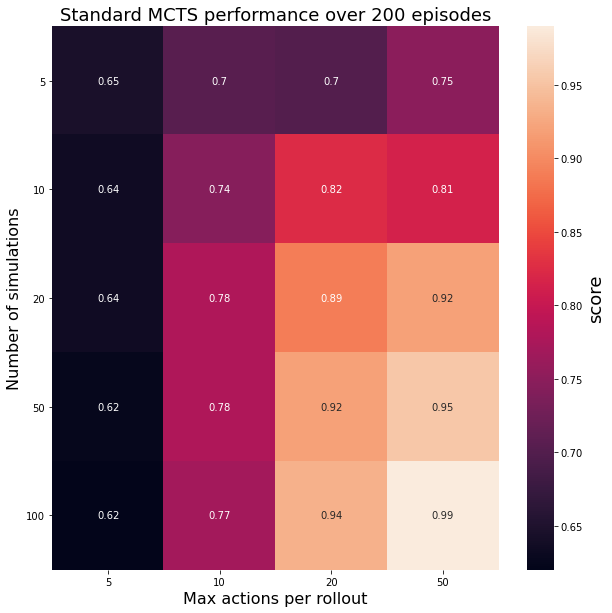

In [32]:
import seaborn as sns
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
sns.heatmap(values, 
            vmin = values.min(),
            vmax = values.max(),
            ax = ax,
            annot = True, 
            cbar_kws = {'label' : 'score'})

N_index = ['%d'%n for n in num_simulations]
ax.set_yticklabels(N_index, rotation = 0)
ax.set_ylabel('Number of simulations', fontsize = 16)
ax.figure.axes[-1].yaxis.label.set_size(18)

A_index = ['%d'%a for a in actions]
ax.set_xticklabels(A_index, rotation = 0)
ax.set_xlabel('Max actions per rollout', fontsize = 16)


ax.set_title("Standard MCTS performance over %d episodes"%test_episodes, fontsize = 18)

In [33]:
times = benchmark["results"]

In [ ]:
keys = list(sorted(results))
values = []
for k in keys:
    values.append(results[k])
values = np.array(values).reshape((len(num_simulations),len(actions)))
values

### Test 2

In [4]:
%%time
# using mode="predict"
Q_value_selection, count_selection = mcts.compare_selection_methods(
                                                game_simulator, value_net, episode_length, ucb_C, 
                                                discount, max_actions, num_simulations, n_episodes=100)
print("Average performance selecting child with highest Q-value: %.2f"%Q_value_selection)
print("Average performance selecting child with highest visit count: %.2f"%count_selection)


Selection mode: Q value

██████
█@   █
█  y █
█n   █
█?!  █
██████


██████
█ @  █
█  y █
█n   █
█?!  █
██████


██████
█    █
█ @y █
█n   █
█?!  █
██████


██████
█    █
█  @ █
█n   █
█?!  █
██████
gleaming sword

██████
█    █
█    █
█n @ █
█?!  █
██████
gleaming sword

██████
█    █
█    █
█n   █
█?!@ █
██████
gleaming sword

██████
█    █
█    █
█n   █
█?@  █
██████
gleaming sword

Mode: highest count

██████
█@   █
█  y █
█n   █
█?!  █
██████


██████
█ @  █
█  y █
█n   █
█?!  █
██████


██████
█  @ █
█  y █
█n   █
█?!  █
██████


██████
█   @█
█  y █
█n   █
█?!  █
██████


██████
█  @ █
█  y █
█n   █
█?!  █
██████


██████
█   @█
█  y █
█n   █
█?!  █
██████


██████
█  @ █
█  y █
█n   █
█?!  █
██████


██████
█   @█
█  y █
█n   █
█?!  █
██████


██████
█  @ █
█  y █
█n   █
█?!  █
██████


██████
█   @█
█  y █
█n   █
█?!  █
██████


██████
█  @ █
█  y █
█n   █
█?!  █
██████


██████
█   @█
█  y █
█n   █
█?!  █
██████


██████
█  @ █
█  y █
█n   █
█?!  █
██████


██████
█   @█
█  

In [7]:
torch.save(Q_value_selection, "Q_value_selection")
torch.save(count_selection, "count_selection")

### Test 6

In [3]:
%%time
untrained_value_net = mcts.FixedDynamicsValueNet(gym_env).to(device)
value_net = torch.load("value_net_boot")
trained_score, untraind_score = mcts.compare_with_untrained_net(game_simulator, value_net, untrained_value_net,
                                                           episode_length, ucb_C, discount, max_actions, 
                                                           num_simulations, n_episodes=100)
print("Average performance with trained value net: %.2f"%trained_score)
print("Average performance swith untrained value net: %.2f"%untraind_score)


Network: trained

██████
█ n? █
█    █
█ @ !█
█y   █
██████


██████
█ n? █
█    █
█@  !█
█y   █
██████


██████
█ n? █
█    █
█   !█
█@   █
██████
shimmering sword

██████
█ n? █
█    █
█   !█
█ @  █
██████
shimmering sword

██████
█ n? █
█    █
█   !█
█  @ █
██████
shimmering sword

██████
█ n? █
█    █
█   !█
█   @█
██████
shimmering sword

██████
█ n? █
█    █
█   @█
█    █
██████
shimmering sword

Network: untrained

██████
█ n? █
█    █
█ @ !█
█y   █
██████


██████
█ n? █
█    █
█ @ !█
█y   █
██████


██████
█ n? █
█    █
█ @ !█
█y   █
██████


██████
█ n? █
█    █
█ @ !█
█y   █
██████


██████
█ n? █
█    █
█ @ !█
█y   █
██████


██████
█ n? █
█    █
█ @ !█
█y   █
██████


██████
█ n? █
█    █
█ @ !█
█y   █
██████


██████
█ n? █
█    █
█   !█
█y@  █
██████


██████
█ n? █
█    █
█ @ !█
█y   █
██████


██████
█ n? █
█    █
█ @ !█
█y   █
██████


██████
█ n? █
█    █
█ @ !█
█y   █
██████


██████
█ n? █
█    █
█   !█
█y@  █
██████


██████
█ n? █
█    █
█   !█
█y@  █
██████


█

TypeError: must be real number, not FixedDynamicsValueNet

In [4]:
print("Average performance with trained value net: %.2f"%trained_score)
print("Average performance swith untrained value net: %.2f"%untraind_score)

Average performance with trained value net: 0.41
Average performance swith untrained value net: 0.27


### Test 5

In [24]:
# Train the network
discrete_v_net = mcts.DiscreteSupportValueNet(gym_env).to(device)
rb = torch.load("replay_buffer_boot")
optimizer = torch.optim.Adam(discrete_v_net.parameters(), lr=1e-3)

n_updates = 1000
losses = []
for i in range(n_updates):
    frames, targets = rb.get_batch(64)
    reshaped_frames = {}
    for k in frames.keys():
        shape = frames[k].shape
        reshaped_frames[k] = frames[k].reshape(-1,*shape[2:])
    targets = targets.reshape(-1,1).to(device)
    discrete_targets = mcts.scalar_to_support(targets, discrete_v_net.support_size).squeeze()
    values = discrete_v_net.logits(reshaped_frames)
    #print("values.shape: ", values.shape)
    #print("discrete_targets.shape: ", discrete_targets.shape)
    loss = (-discrete_targets * torch.nn.LogSoftmax(dim=1)(values)).sum()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print("Update: %d - Loss: %.4f"%(i+1,loss.item()))
    losses.append(loss.item())

Update: 1 - Loss: 1640.3821
Update: 2 - Loss: 1488.2153
Update: 3 - Loss: 1266.1643
Update: 4 - Loss: 1009.8692
Update: 5 - Loss: 896.2554
Update: 6 - Loss: 881.9650
Update: 7 - Loss: 850.2130
Update: 8 - Loss: 769.3213
Update: 9 - Loss: 773.5834
Update: 10 - Loss: 830.2455
Update: 11 - Loss: 780.2906
Update: 12 - Loss: 794.4711
Update: 13 - Loss: 751.7546
Update: 14 - Loss: 792.4926
Update: 15 - Loss: 730.4202
Update: 16 - Loss: 780.0914
Update: 17 - Loss: 779.0704
Update: 18 - Loss: 745.0084
Update: 19 - Loss: 745.1866
Update: 20 - Loss: 752.1070
Update: 21 - Loss: 767.9189
Update: 22 - Loss: 768.8955
Update: 23 - Loss: 759.7794
Update: 24 - Loss: 749.6726
Update: 25 - Loss: 729.3494
Update: 26 - Loss: 745.8304
Update: 27 - Loss: 721.8611
Update: 28 - Loss: 702.1572
Update: 29 - Loss: 773.3425
Update: 30 - Loss: 753.7024
Update: 31 - Loss: 738.1387
Update: 32 - Loss: 776.8541
Update: 33 - Loss: 711.0118
Update: 34 - Loss: 728.4589
Update: 35 - Loss: 703.6628
Update: 36 - Loss: 711.95

Update: 293 - Loss: 745.6292
Update: 294 - Loss: 756.3137
Update: 295 - Loss: 721.7280
Update: 296 - Loss: 721.7843
Update: 297 - Loss: 726.0583
Update: 298 - Loss: 723.7103
Update: 299 - Loss: 730.9272
Update: 300 - Loss: 727.0095
Update: 301 - Loss: 714.7461
Update: 302 - Loss: 698.4573
Update: 303 - Loss: 720.3253
Update: 304 - Loss: 737.3586
Update: 305 - Loss: 742.1743
Update: 306 - Loss: 734.2411
Update: 307 - Loss: 723.6132
Update: 308 - Loss: 722.0269
Update: 309 - Loss: 708.9783
Update: 310 - Loss: 716.9675
Update: 311 - Loss: 738.5778
Update: 312 - Loss: 734.2473
Update: 313 - Loss: 692.1329
Update: 314 - Loss: 736.0632
Update: 315 - Loss: 705.5826
Update: 316 - Loss: 761.6412
Update: 317 - Loss: 690.8912
Update: 318 - Loss: 718.8480
Update: 319 - Loss: 717.9196
Update: 320 - Loss: 725.4377
Update: 321 - Loss: 727.3113
Update: 322 - Loss: 731.8772
Update: 323 - Loss: 686.7416
Update: 324 - Loss: 761.4868
Update: 325 - Loss: 715.7896
Update: 326 - Loss: 696.5809
Update: 327 - 

Update: 587 - Loss: 713.3623
Update: 588 - Loss: 687.9018
Update: 589 - Loss: 698.6287
Update: 590 - Loss: 674.7815
Update: 591 - Loss: 707.4130
Update: 592 - Loss: 700.8884
Update: 593 - Loss: 703.3945
Update: 594 - Loss: 703.8275
Update: 595 - Loss: 691.4651
Update: 596 - Loss: 675.1772
Update: 597 - Loss: 687.9679
Update: 598 - Loss: 680.8621
Update: 599 - Loss: 714.7671
Update: 600 - Loss: 687.0526
Update: 601 - Loss: 680.8940
Update: 602 - Loss: 670.0993
Update: 603 - Loss: 692.0447
Update: 604 - Loss: 691.3074
Update: 605 - Loss: 693.0577
Update: 606 - Loss: 691.2280
Update: 607 - Loss: 693.5354
Update: 608 - Loss: 685.1923
Update: 609 - Loss: 701.6648
Update: 610 - Loss: 716.8840
Update: 611 - Loss: 673.7944
Update: 612 - Loss: 685.7965
Update: 613 - Loss: 689.1865
Update: 614 - Loss: 696.4390
Update: 615 - Loss: 695.4164
Update: 616 - Loss: 691.7313
Update: 617 - Loss: 680.3840
Update: 618 - Loss: 694.5474
Update: 619 - Loss: 698.2948
Update: 620 - Loss: 683.3048
Update: 621 - 

Update: 881 - Loss: 655.0815
Update: 882 - Loss: 645.7303
Update: 883 - Loss: 661.9550
Update: 884 - Loss: 635.9071
Update: 885 - Loss: 643.8525
Update: 886 - Loss: 646.8897
Update: 887 - Loss: 649.7817
Update: 888 - Loss: 637.6309
Update: 889 - Loss: 646.1383
Update: 890 - Loss: 626.5048
Update: 891 - Loss: 638.1376
Update: 892 - Loss: 650.5800
Update: 893 - Loss: 668.0912
Update: 894 - Loss: 639.5708
Update: 895 - Loss: 649.0986
Update: 896 - Loss: 634.4719
Update: 897 - Loss: 629.2538
Update: 898 - Loss: 632.6763
Update: 899 - Loss: 654.8186
Update: 900 - Loss: 666.3444
Update: 901 - Loss: 621.2315
Update: 902 - Loss: 651.2522
Update: 903 - Loss: 637.0580
Update: 904 - Loss: 648.2407
Update: 905 - Loss: 656.6680
Update: 906 - Loss: 648.0536
Update: 907 - Loss: 641.7554
Update: 908 - Loss: 648.0976
Update: 909 - Loss: 637.0728
Update: 910 - Loss: 630.4869
Update: 911 - Loss: 639.8843
Update: 912 - Loss: 660.6383
Update: 913 - Loss: 630.3309
Update: 914 - Loss: 659.5247
Update: 915 - 

In [25]:
%%time
score = []
for i in range(100):
    total_reward, _, _ , _ = mcts.play_episode_value_net(
                                                    discrete_v_net,
                                                    game_simulator,
                                                    episode_length,
                                                    ucb_C,
                                                    discount,
                                                    max_actions,
                                                    num_simulations,
                                                    mode="predict"
                                                    )
    score.append(total_reward)
print("Average performance discrete support value net MCTS: %.2f"%np.mean(score))

Average performance discrete support value net MCTS: 0.25
CPU times: user 6min 43s, sys: 322 ms, total: 6min 44s
Wall time: 6min 43s


In [20]:
# Train the network
v_net = mcts.FixedDynamicsValueNet(gym_env).to(device)
rb = torch.load("replay_buffer_boot")
optimizer = torch.optim.Adam(v_net.parameters(), lr=1e-3)
loss_fn = F.mse_loss

losses = []
n_updates = 1000
for i in range(n_updates):
    frames, targets = rb.get_batch(64)
    reshaped_frames = {}
    for k in frames.keys():
        shape = frames[k].shape
        reshaped_frames[k] = frames[k].reshape(-1,*shape[2:])
    targets = targets.reshape(-1).to(device)
    values = v_net(reshaped_frames).squeeze(1)
    
    loss = loss_fn(values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print("Update: %d - Loss: %.4f"%(i+1,loss.item()))
    losses.append(loss.item())

Update: 1 - Loss: 0.6121
Update: 2 - Loss: 0.3668
Update: 3 - Loss: 0.1459
Update: 4 - Loss: 0.4201
Update: 5 - Loss: 0.2972
Update: 6 - Loss: 0.1893
Update: 7 - Loss: 0.2262
Update: 8 - Loss: 0.3096
Update: 9 - Loss: 0.2552
Update: 10 - Loss: 0.2651
Update: 11 - Loss: 0.1912
Update: 12 - Loss: 0.1871
Update: 13 - Loss: 0.2394
Update: 14 - Loss: 0.2364
Update: 15 - Loss: 0.1638
Update: 16 - Loss: 0.1789
Update: 17 - Loss: 0.2133
Update: 18 - Loss: 0.2135
Update: 19 - Loss: 0.1792
Update: 20 - Loss: 0.1843
Update: 21 - Loss: 0.2343
Update: 22 - Loss: 0.2457
Update: 23 - Loss: 0.2061
Update: 24 - Loss: 0.2441
Update: 25 - Loss: 0.1702
Update: 26 - Loss: 0.1574
Update: 27 - Loss: 0.1832
Update: 28 - Loss: 0.1782
Update: 29 - Loss: 0.2690
Update: 30 - Loss: 0.1514
Update: 31 - Loss: 0.1488
Update: 32 - Loss: 0.2281
Update: 33 - Loss: 0.1891
Update: 34 - Loss: 0.1482
Update: 35 - Loss: 0.2150
Update: 36 - Loss: 0.1927
Update: 37 - Loss: 0.1284
Update: 38 - Loss: 0.1569
Update: 39 - Loss: 0.

Update: 312 - Loss: 0.1683
Update: 313 - Loss: 0.1415
Update: 314 - Loss: 0.1253
Update: 315 - Loss: 0.0986
Update: 316 - Loss: 0.1300
Update: 317 - Loss: 0.1329
Update: 318 - Loss: 0.1475
Update: 319 - Loss: 0.1469
Update: 320 - Loss: 0.1121
Update: 321 - Loss: 0.0947
Update: 322 - Loss: 0.1029
Update: 323 - Loss: 0.0917
Update: 324 - Loss: 0.1578
Update: 325 - Loss: 0.1238
Update: 326 - Loss: 0.1585
Update: 327 - Loss: 0.0862
Update: 328 - Loss: 0.1216
Update: 329 - Loss: 0.0923
Update: 330 - Loss: 0.1324
Update: 331 - Loss: 0.1489
Update: 332 - Loss: 0.1681
Update: 333 - Loss: 0.0874
Update: 334 - Loss: 0.1277
Update: 335 - Loss: 0.1272
Update: 336 - Loss: 0.1226
Update: 337 - Loss: 0.0965
Update: 338 - Loss: 0.1126
Update: 339 - Loss: 0.1337
Update: 340 - Loss: 0.1470
Update: 341 - Loss: 0.1420
Update: 342 - Loss: 0.1215
Update: 343 - Loss: 0.0907
Update: 344 - Loss: 0.1167
Update: 345 - Loss: 0.1209
Update: 346 - Loss: 0.1236
Update: 347 - Loss: 0.1063
Update: 348 - Loss: 0.0873
U

Update: 627 - Loss: 0.0253
Update: 628 - Loss: 0.0207
Update: 629 - Loss: 0.0194
Update: 630 - Loss: 0.0215
Update: 631 - Loss: 0.0173
Update: 632 - Loss: 0.0222
Update: 633 - Loss: 0.0307
Update: 634 - Loss: 0.0194
Update: 635 - Loss: 0.0224
Update: 636 - Loss: 0.0281
Update: 637 - Loss: 0.0171
Update: 638 - Loss: 0.0193
Update: 639 - Loss: 0.0232
Update: 640 - Loss: 0.0216
Update: 641 - Loss: 0.0299
Update: 642 - Loss: 0.0201
Update: 643 - Loss: 0.0191
Update: 644 - Loss: 0.0238
Update: 645 - Loss: 0.0211
Update: 646 - Loss: 0.0236
Update: 647 - Loss: 0.0188
Update: 648 - Loss: 0.0215
Update: 649 - Loss: 0.0263
Update: 650 - Loss: 0.0118
Update: 651 - Loss: 0.0246
Update: 652 - Loss: 0.0183
Update: 653 - Loss: 0.0128
Update: 654 - Loss: 0.0160
Update: 655 - Loss: 0.0171
Update: 656 - Loss: 0.0140
Update: 657 - Loss: 0.0205
Update: 658 - Loss: 0.0151
Update: 659 - Loss: 0.0178
Update: 660 - Loss: 0.0168
Update: 661 - Loss: 0.0161
Update: 662 - Loss: 0.0204
Update: 663 - Loss: 0.0155
U

Update: 942 - Loss: 0.0094
Update: 943 - Loss: 0.0078
Update: 944 - Loss: 0.0056
Update: 945 - Loss: 0.0145
Update: 946 - Loss: 0.0079
Update: 947 - Loss: 0.0077
Update: 948 - Loss: 0.0065
Update: 949 - Loss: 0.0079
Update: 950 - Loss: 0.0074
Update: 951 - Loss: 0.0072
Update: 952 - Loss: 0.0082
Update: 953 - Loss: 0.0100
Update: 954 - Loss: 0.0099
Update: 955 - Loss: 0.0098
Update: 956 - Loss: 0.0145
Update: 957 - Loss: 0.0064
Update: 958 - Loss: 0.0082
Update: 959 - Loss: 0.0061
Update: 960 - Loss: 0.0056
Update: 961 - Loss: 0.0062
Update: 962 - Loss: 0.0077
Update: 963 - Loss: 0.0038
Update: 964 - Loss: 0.0062
Update: 965 - Loss: 0.0068
Update: 966 - Loss: 0.0050
Update: 967 - Loss: 0.0069
Update: 968 - Loss: 0.0076
Update: 969 - Loss: 0.0068
Update: 970 - Loss: 0.0056
Update: 971 - Loss: 0.0054
Update: 972 - Loss: 0.0047
Update: 973 - Loss: 0.0050
Update: 974 - Loss: 0.0072
Update: 975 - Loss: 0.0079
Update: 976 - Loss: 0.0072
Update: 977 - Loss: 0.0064
Update: 978 - Loss: 0.0069
U

In [22]:
%%time
score = []
for i in range(100):
    total_reward, _, _ , _ = mcts.play_episode_value_net(
                                                    v_net,
                                                    game_simulator,
                                                    episode_length,
                                                    ucb_C,
                                                    discount,
                                                    max_actions,
                                                    num_simulations,
                                                    mode="predict"
                                                    )
    score.append(total_reward)
print("Average performance standard value net MCTS: %.2f"%np.mean(score))

Average performance standard value net MCTS: 0.50
CPU times: user 5min 7s, sys: 294 ms, total: 5min 7s
Wall time: 5min 7s
